In [1]:
! pip install gpytorch

In [2]:
import numpy as np
import pandas as pd
from scipy.stats import qmc
from scipy.optimize import minimize

import torch

import matplotlib.pyplot as plt
FONTSIZE = 14
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : FONTSIZE}
import matplotlib as mp
mp.rc('font', **font)

# set usetex = False if LaTex is not
# available on your system or if the
# rendering is too slow
mp.rc('text', usetex=False)


import gpytorch
from gpytorch.means import ConstantMean
from gpytorch.kernels import ScaleKernel, RBFKernel
from gpytorch.distributions import MultivariateNormal

#`source /cvmfs/sft.cern.ch/lcg/views/LCG_102/x86_64-centos7-gcc11-opt/setup.sh`
from glob import glob
from tqdm import tqdm

In [3]:

PARAM_DICT = {
        'StringZ:aLund' : [0, 2.0],
        'StringZ:bLund': [0.2, 2.0],
        'StringZ:rFactC':[0.0, 2.0],
        'StringZ:rFactB': [0., 2.0],
        'StringZ:aExtraSQuark':[0.,2.],
        'StringZ:aExtraDiquark':[0.,2.],
        'StringPT:sigma':[0.,1.],
        'StringPT:enhancedFraction':[0.,1.],
        'StringPT:enhancedWidth':[1.0,4.0],
        'TimeShower:alphaSvalue':[0.06,0.25],
        'TimeShower:pTmin':[0.1,2.0]
}

MONASH_DICT = {
    "aLund" : 0.68,
    "bLund" : 0.98,
    "rFactC": 1.32,
    "rFactB":0.855,
    "aExtraSQuark": 0.0,
    "aExtraDiquark":0.97,
    "sigma":0.335,
    "enhancedFraction":0.01,
    "enhancedWidth":2.0,
    "alphaSvalue": 0.1365,
    "pTmin": 0.5
}

In [4]:
def get_param_prefix(param):
    for key,val in PARAM_DICT.items():
        prefix, postfix = key.split(':')
        if postfix == str(param):
            return prefix


In [5]:
class Sample_param:
    def __init__(self, param, size):
        self.param = param
        self.size = size
        param_prefix = get_param_prefix(self.param)
        pre_postfix = param_prefix + ':' + self.param
        self.min = PARAM_DICT[pre_postfix][0]
        self.max = PARAM_DICT[pre_postfix][1]

    def uniform(self):
        return torch.tensor(np.random.uniform(
                low=self.min,
                high=self.max,
                size=self.size))

    def linspace(self):
        return torch.linspace(start=self.min,
                end=self.max,
                steps=self.size)

    def scale_sample(self, sample):
        return sample * (self.max - self.min) + self.min

In [6]:
def make_sobol_candidates(PARAM_DICT, size):
    num_params = len(PARAM_DICT)

    # Create a single Sobol sampler for all dimensions
    sampler = qmc.Sobol(d=num_params, scramble=True)

    # Generate samples
    samples = sampler.random(n=size)

    # Scale samples for each parameter
    scaled_samples = np.empty_like(samples)
    for ind, (key, val) in enumerate(PARAM_DICT.items()):
        param_name, range_ = key, val
        param_postfix = param_name.split(':')[1]
        param_sampler = Sample_param(param=param_postfix, size=size)
        scaled_samples[:, ind] = param_sampler.scale_sample(samples[:, ind])

    return torch.tensor(scaled_samples,requires_grad=True)


In [7]:
def make_x_candidates(PARAM_DICT, size):
    """
    Example: x_candidates = make_x_candidates(PARAM_DICT,2)
    """
    full_matrix = np.empty((size, len(PARAM_DICT)))

    for row in range(size):
        result=[]
        for key, val in PARAM_DICT.items():
            param_name, range_ = key, val
            param_postfix = param_name.split(':')[1]
            uniform_size_1 = Sample_param(param=param_postfix, size=1).uniform().item()
            result.append(uniform_size_1)
        full_matrix[row,:] = result

    result = full_matrix

    # print(result)
    return torch.tensor(result, requires_grad=True)

In [8]:
def compare_uniform_sobol(PARAM_DICT,size):
    fig, ax = plt.subplots(1,2,figsize=(10,5))
    uniform_candidates = make_x_candidates(PARAM_DICT,size).detach().numpy()
    a_uniform = uniform_candidates[:,0]
    b_uniform = uniform_candidates[:,1]
    ax[0].scatter(a_uniform, b_uniform)
    ax[0].set_title('Uniform MC')

    sobol_candidates = make_sobol_candidates(PARAM_DICT,size)
    sobol_candidates=sobol_candidates.detach().numpy()
    a_sobol=sobol_candidates[:,0]
    b_sobol=sobol_candidates[:,1]
    ax[1].scatter(a_sobol, b_sobol)
    ax[1].set_title('Sobol')

    for i in range(2):
        ax[i].set_xlabel('aLund')
        ax[i].set_ylabel('bLund')
    plt.tight_layout()
    plt.show()

In [9]:
POINT2 = {key:0.5*value for key, value in MONASH_DICT.items()}
POINT3 = {key:1.5*value for key, value in MONASH_DICT.items()}

In [10]:
POINT2

{'aLund': 0.34,
 'bLund': 0.49,
 'rFactC': 0.66,
 'rFactB': 0.4275,
 'aExtraSQuark': 0.0,
 'aExtraDiquark': 0.485,
 'sigma': 0.1675,
 'enhancedFraction': 0.005,
 'enhancedWidth': 1.0,
 'alphaSvalue': 0.06825,
 'pTmin': 0.25}

In [11]:
POINT3

{'aLund': 1.02,
 'bLund': 1.47,
 'rFactC': 1.98,
 'rFactB': 1.2825,
 'aExtraSQuark': 0.0,
 'aExtraDiquark': 1.455,
 'sigma': 0.5025000000000001,
 'enhancedFraction': 0.015,
 'enhancedWidth': 3.0,
 'alphaSvalue': 0.20475000000000002,
 'pTmin': 0.75}

In [12]:
def quadratic_form(point, values):
  y = 0
  scale = 1
  for x, (key, value) in zip(point, values.items()):
    y += scale * (x-value)**2
    scale *= 1.2
  return y

def true_objective_func(aLund,
                     bLund,
                    rFactC,
                    rFactB,
                    aExtraSQuark,
                    aExtraDiquark,
                    sigma,
                    enhancedFraction,
                    enhancedWidth,
                    alphaSvalue,
                    pTmin
                        ):
    # each minimum is a quadratic term
    # 3 minima
    point =         [aLund,
                     bLund,
                    rFactC,
                    rFactB,
                    aExtraSQuark,
                    aExtraDiquark,
                    sigma,
                    enhancedFraction,
                    enhancedWidth,
                    alphaSvalue,
                    pTmin
                     ]

    y1 = quadratic_form(point, MONASH_DICT)

    ONE_MINIMUM=True
    if ONE_MINIMUM:
      result = y1
    else:
      y2 = quadratic_form(point, POINT2)
      y3 = quadratic_form(point, POINT3)
      result = np.sqrt(y1 * (y2+1.0) * (y3+2.0))#/400
    return result# + np.random.normal(0,1)#random noise

In [13]:
def make_multidim_xstar(model, param,size):
    """
    This is used for sampling the parameters for plotting
    """
    train_x = model.train_inputs[0].numpy()
    train_y = model.train_targets.numpy()
    train_x = train_x[train_y.argmin()]


    x_star0 = Sample_param(param,size).linspace()
    empty = np.ones((size, len(PARAM_DICT)))
    for param_indx in np.arange(len(PARAM_DICT)):
        empty[:,param_indx] = train_x[param_indx]
    # empty = make_x_candidates(PARAM_DICT, size)
    param_prefix = get_param_prefix(param)
    full_param_name = param_prefix + ':' + param
    param_index = param_names.index(full_param_name)
    empty[:,param_index] = x_star0
    # print(empty)
    return torch.tensor(empty)

In [14]:
def make_train_dataset(PARAM_DICT, points, ONLY_MONASH_TRAIN=False):
    param_names = list(PARAM_DICT.keys())
    column_names = param_names + ['chi2']

    rows = []
    for _ in range(points):
        row = []
        for param_name, range_ in PARAM_DICT.items():
            param_postfix = param_name.split(':')[1]
            uniform_size_1 = Sample_param(param=param_postfix, size=1).uniform().item()
            row.append(uniform_size_1)

        chi2 = true_objective_func(*row)
        row.append(chi2)
        rows.append(row)

    df = pd.DataFrame(rows, columns=column_names)
    return df

In [15]:
class GPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, kernel='RBF', heteroscedastic=False):
        super(GPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = ConstantMean()
        if kernel == 'RBF':
          self.covar_module = ScaleKernel(RBFKernel(
              ard_num_dims=train_x.size(-1),
              # lengthscale_prior=gpytorch.priors.LogNormalPrior(loc= torch.log(torch.tensor([train_x.size(-1)/2])), scale=1)
          ))
        elif kernel == 'Matern':
          self.covar_module = ScaleKernel(gpytorch.kernels.MaternKernel(ard_num_dims=train_x.size(-1),
                                                                    #  lengthscale_prior=gpytorch.priors.LogNormalPrior(loc= torch.log(torch.tensor([train_x.size(-1)/2])), scale=1)
                                                                    )
          )
        elif kernel == 'RQ':
          self.covar_module = ScaleKernel(gpytorch.kernels.RQKernel(
              ard_num_dims=train_x.size(-1)
          ))
        elif kernel == 'Cosine':
          self.covar_module = ScaleKernel(gpytorch.kernels.CosineKernel(
              ard_num_dims=train_x.size(-1)
          ))

        elif kernel == 'Polynomial':
          self.covar_module = ScaleKernel(gpytorch.kernels.PolynomialKernel(power=5,
              ard_num_dims=train_x.size(-1)
          ))
        elif kernel == 'SpectralMixture':
            self.covar_module = gpytorch.kernels.SpectralMixtureKernel(num_mixtures=4,
              ard_num_dims=train_x.size(-1)
          )
            self.covar_module.initialize_from_data(train_x, train_y)

        self.heteroscedastic=heteroscedastic
        if heteroscedastic:
          self.noise_model = gpytorch.means.LinearMean(input_size=train_x.size(-1))


    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        if self.heteroscedastic:
          noise = self.noise_model(x).exp().diag()
        else:
          noise=0
        return MultivariateNormal(mean_x, covar_x + noise)

    def predict(self, train_x):
        self.eval()
        self.likelihood.eval()
        with torch.no_grad():
            pred = self(train_x)
        return self.likelihood(pred)


In [16]:
def plot_model_param(model,param, ax, filter_observed_data = False,  set_xy_lim=False):
    train_x = model.train_inputs[0].numpy()
    param_prefix = get_param_prefix(param)
    full_param_name = param_prefix + ':' + param
    param_index = param_names.index(full_param_name)

    train_x_param = train_x[:,param_index]
    train_y = model.train_targets.numpy()

    if train_x.shape[1] == 1 or train_x.ndim ==1:
        x_star = torch.linspace(train_x.min(), train_x.max(), 2000)
    else:
        # x_star = make_x_candidates(PARAM_DICT,200)
        x_star  = make_multidim_xstar(model, param,2000)

    model.eval()
    model.likelihood.eval()
    predictive_distribution = model.predict(x_star)
    lower, upper = predictive_distribution.confidence_region()
    pred = predictive_distribution.mean.numpy()

    if train_x.shape[1] == 1 or train_x.ndim ==1:
        x_star_param =x_star.numpy()
    else:
      x_star_param =x_star[:,param_index].numpy()
    ax.plot(x_star_param, pred, label='GP Mean Prediction', color='red')
    ax.fill_between(x_star_param, lower.detach().numpy(), upper.detach().numpy(), alpha=0.5)

    if filter_observed_data:
        train_x_param_other_prams_close_to_1, train_y_all_other_params_close_to_1 = filter_data_other_params_close_to_one(param, train_x, train_y)
        ax.plot(train_x_param_other_prams_close_to_1, train_y_all_other_params_close_to_1, 'k*', label='Observed Data', alpha=0.5)
    else:
        ax.plot(train_x_param, train_y, 'k*', label='Observed Data', alpha=0.5)
    # y_upper = upper.detach().numpy().max() * 1.5
    # y_lower = 0#lower.detach().numpy().max()
    # ax.set_ylim(y_lower, y_upper)
    ax.legend()
    ax.set_xlabel(param)
    ax.set_ylabel(r'$\lambda$')
    if set_xy_lim:
      ax.set_xlim(PARAM_DICT[full_param_name])
      if len(PARAM_DICT) <= 2:
        ax.set_ylim(-4,10)
      else:
        ax.set_ylim(-4,60)
    plt.tight_layout()

In [17]:
def plot_all(set_xy_lim=False):
  fig, axs = plt.subplots(4,3,figsize=(17,14))
  axs=axs.ravel()[:-1]
  pram_postfixs = [p.split(':')[1] for p in param_names]
  for axind, ax in enumerate(axs):
    plot_model_param(model, pram_postfixs[axind], ax,filter_observed_data = False,  set_xy_lim=set_xy_lim)


In [18]:
def print_parameters(model):
    state_dict = model.state_dict()
    for param_name, param_tensor in state_dict.items():
        print(param_name, param_tensor)

In [19]:
def train_model(model, train_x, train_y, n_epochs, print_=False):
    optimizer = torch.optim.Adam(model.parameters(), lr=2e-2)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(model.likelihood, model )

    model.train()
    model.likelihood.train()

    eps=2e-6
    loss_prev = torch.tensor([np.inf])
    for epoch in range(n_epochs):
        optimizer.zero_grad()
        output = model(train_x)  # Use model() instead of model.predict()
        loss = -mll(output, train_y)

        if print_:
            print(f'Epoch {epoch + 1}/{n_epochs} - Loss: {loss.item():.3f}   '
                  f'lengthscale: {model.covar_module.base_kernel.lengthscale.tolist()[0]}   '
                  f'noise: {model.likelihood.noise.item():.3f}')



        loss.backward()
        optimizer.step()
        if torch.abs(loss_prev-loss) < eps:
          break
        loss_prev = loss

    model.eval()
    # model.likelihood.eval()
    return model

In [20]:
def expected_improvement(model, observed_y, candidate_set):
    model.eval()
    model.likelihood.eval()
    # Don't do candidate_set = torch.tensor(candidate_set,requires_grad=True), it stops the computation graph!
    candidate_set = candidate_set.reshape(1,-1)

    with gpytorch.settings.fast_pred_var():
        observed_pred = model(candidate_set)  # Use model() instead of model.predict()
        best_f = observed_y.min()

        mean = observed_pred.mean
        sigma = observed_pred.variance.sqrt()

        # Compute z (not gamma)
        z = (best_f - mean) / sigma

        # Compute EI
        normal = torch.distributions.Normal(0, 1)
        ei = sigma * (z * normal.cdf(z) + normal.log_prob(z).exp())

        # Set EI to 0 where sigma is 0 (to avoid NaN)
        ei = torch.where(sigma > 0, ei, torch.zeros_like(ei))
    # print('candidate set', candidate_set)
    # print('ei output', ei)
    return ei

def expected_improvement_numpy(model, observed_y, candidate_set):

    candidate_set = torch.tensor(candidate_set).reshape(1,-1)
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        observed_pred = model(candidate_set)  # Use model() instead of model.predict()
        best_f = observed_y.min()

        mean = observed_pred.mean
        sigma = observed_pred.variance.sqrt()

        # Compute z (not gamma)
        z = (best_f - mean) / sigma

        # Compute EI
        normal = torch.distributions.Normal(0, 1)
        ei = sigma * (z * normal.cdf(z) + normal.log_prob(z).exp())

        # Set EI to 0 where sigma is 0 (to avoid NaN)
        ei = torch.where(sigma > 0, ei, torch.zeros_like(ei))

    return ei

def ucb(model, candidate_set, kappa=1.5):
    with gpytorch.settings.fast_pred_var():
        pred = model(candidate_set)
    return pred.mean + kappa * pred.stddev

In [21]:
def clip_to_bounds(x):
  x = x.detach().numpy()
  x_clipped = np.ones_like(x)
  bounds = list(PARAM_DICT.values())
  for ind, (param_element, param_range) in enumerate(zip(x, bounds)):
    if param_element < param_range[0]:
      x_clipped[ind] = param_range[0]
    elif param_element > param_range[1]:
      x_clipped[ind] = param_range[1]
    else:
      x_clipped[ind] = param_element
  return torch.tensor(x_clipped)

In [22]:
def optimize_acq(acquisition_func,
                n_optimize_acq_iter=200,
                 n_restarts=5
                 ):
  best_x = None
  best_acq_value=float('inf')


  if num_params <= 2:
    lr = 0.1
  else:
    lr = 0.1

  for _ in range(n_restarts):
    x_candidates = make_sobol_candidates(PARAM_DICT,1)#.reshape(-1)
    optimizer = torch.optim.Adam([x_candidates],lr=lr)
    loss_prev = torch.tensor([np.inf])
    for i in range(n_optimize_acq_iter):
      optimizer.zero_grad()
      loss= - acquisition_func(model, train_y, x_candidates)
      loss.requires_grad_(True)
      loss.backward()
      optimizer.step()
      if loss.item() < best_acq_value:
        best_acq_value =  loss.item()
        best_x = x_candidates.reshape(-1)
        best_x = clip_to_bounds(best_x)
        # break
      # loss_prev = loss

  # best_x = best_x.reshape(-1)

  return best_x

In [23]:
def optimize_acq_2(acquisition_func,
                   x_candidates
                   ):
  n_optimize_acq_iter=10000
  if num_params <= 2:
    lr = 0.1
  else:
    lr = 0.06
  optimizer = torch.optim.Adam([x_candidates],lr=lr)
  eps=1e-8
  loss_prev = torch.tensor([np.inf])
  for i in range(n_optimize_acq_iter):
    optimizer.zero_grad()
    loss= - acquisition_func(model, train_y, x_candidates)
    loss.requires_grad_(True)
    loss.backward()
    optimizer.step()
    if torch.abs(loss_prev-loss) < eps:
      break
    loss_prev = loss
  return x_candidates.detach().reshape(-1)

In [24]:
def optimize_acq_3(acq_, num_optimize_iterations, x_init):
  x_init=x_init.clone().detach().requires_grad_(True)
  # print(x_init)
  eps=1e-8
  learning_rate=torch.tensor([0.01])
  loss_prev = torch.tensor([np.inf])
  for i in range(num_optimize_iterations):
    loss= acq_(x_init)
    loss.requires_grad_(True)
    loss.backward()
    # print(x_init.grad)
    with torch.no_grad():
      x_init -= learning_rate * x_init.grad

    x_init.grad.zero_()
    if torch.abs(loss_prev-loss) < eps:
      break
    loss_prev = loss
  return x_init.reshape(-1)

In [41]:
def minimize_acq(acq, n_restarts, minimize_method='SLSQP', jac=None):
  # see https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html for listing of available optimization methods
    best_x = None
    best_acq_value = float('inf')
    bounds = np.array(list(PARAM_DICT.values()))

    for _ in range(n_restarts):
      x0 = make_sobol_candidates(PARAM_DICT,1).detach().numpy().reshape(-1)#x0 has to have one dimension, reshape inside EI_numpy
      # 'L-BFGS-B' 'SLSQP'
      if jac is None:
        res = minimize(acq, x0, bounds=bounds, method=minimize_method)
      else:
        res = minimize(acq, x0, bounds=bounds, method=minimize_method,jac=jac)
      if res.fun < best_acq_value:
          best_acq_value = res.fun
          best_x = res.x
    return torch.tensor(best_x)

In [51]:
bounds = np.array(list(PARAM_DICT.values()))
x0 = make_sobol_candidates(PARAM_DICT,1).detach().numpy().reshape(-1)
res = minimize(acq_numpy, x0, bounds=bounds, method='SLSQP')
res.x

array([1.98832322, 0.42465931, 0.54413777, 1.48230385, 0.39776957,
       0.17424136, 0.22199624, 0.2106969 , 3.57242933, 0.09820906,
       0.92256844])

In [26]:
def acq_(x):
    # Ensure x is a tensor with grad enabled if it's not already
    # x_tensor = x if x.requires_grad else torch.tensor(x, dtype=torch.float64, requires_grad=True)
    return -expected_improvement(model=model, observed_y=train_y, candidate_set=x)



def acq_numpy(x):
  return - expected_improvement_numpy(model, train_y, x).detach().numpy()

def jac_acq_(x):
  x = torch.tensor(x,requires_grad=True)
  F = acq_(x)
  dFdX = torch.autograd.grad(outputs=F, inputs=x,
                               grad_outputs=torch.ones_like(F),
                               allow_unused=True,
                               #retain_graph=True,
                               create_graph=True)#[0]
  Y = dFdX.detach().numpy()
  if len(Y) == 1:
    Y = Y[0]
  return Y

In [27]:
x0 = make_sobol_candidates(PARAM_DICT,1)#.detach().numpy().reshape(-1)
# x = torch.tensor(x0,requires_grad=True)
# x = torch.from_numpy(x0).requires_grad_(True)
# x=x0
F = acq_(x0)
print(F)
dFdX = torch.autograd.grad(outputs=F, inputs=x0,
                               grad_outputs=torch.ones_like(F),
                               allow_unused=True,
                              #  retain_graph=True,
                               create_graph=True)

print(dFdX)

NameError: name 'model' is not defined

In [56]:
minimize_acq(acq=acq_, n_restarts=5, minimize_method='L-BFGS-B', jac=None)

AttributeError: 'numpy.ndarray' object has no attribute 'ndimension'

In [29]:
def jac_acq_2(x):
    x_tensor = torch.tensor(x, requires_grad=True)
    # x_tensor = x_tensor.reshape(1, -1)

    F = acq_(x_tensor)
    F.backward()

    grad = x_tensor.grad
    return grad.numpy().flatten()

In [53]:
def BayesOpt_all_params(model,
                        train_x,
                        train_y,
                        n_iterations,
                        acquisition = 'EI',
                        retrain_gp=False,
                        print_=False,
                       save_model=False,
                        OPTIMIZE_ACQ=False,
                        MINIMIZE_ACQ=False,
                        suggest_monash_point=False,
                        n_optimize_acq_iter=10,
                        n_restarts=25,
                        minimize_method='SLSQP',
                        jac=None):
    # Use the Adam optimizer

    model.eval()
    model.likelihood.eval()

    ONLY_MONASH_TRAIN=False

    if suggest_monash_point:
      Monash_candidate = torch.tensor(list(MONASH_DICT.values()))
      next_y = true_objective_func(*Monash_candidate)
      print(f'objective function at the Monash point = {next_y}')
      if ONLY_MONASH_TRAIN:
          train_x = torch.cat([train_x.unsqueeze(0), Monash_candidate.unsqueeze(0)])
      else:
          train_x = torch.cat([train_x, Monash_candidate.unsqueeze(0)])
      next_y = torch.tensor([next_y])
      if ONLY_MONASH_TRAIN:
          train_y = torch.cat([train_y.unsqueeze(0), next_y])
      else:
          train_y = torch.cat([train_y, next_y])
      model.set_train_data(inputs=train_x, targets=train_y, strict=False)
      train_model(model, train_x, train_y, 5, print_=print_)

    iterations=[]
    true_objecctive_funcs=[]
    for iteration in range(n_iterations):
        iterations.append(iteration)
        if OPTIMIZE_ACQ:
          x_candidates = make_sobol_candidates(PARAM_DICT,1)
          def acq_(x):
            if acquisition == 'EI':
              return - expected_improvement(model, train_y, x)
            elif acquisition == 'UCB':
              return - ucb(model, x)

          if acquisition == 'EI':
              acq = expected_improvement(model, train_y, x_candidates)
          elif acquisition == 'UCB':
              acq = ucb(model, x_candidates)
          # next_x = optimize_acq(acquisition_func=expected_improvement, n_optimize_acq_iter=n_optimize_acq_iter, n_restarts=n_restarts)
          # next_x = optimize_acq_2(acquisition_func=expected_improvement, x_candidates=x_candidates)

          # next_x = optimize_acq_3(acq_=acq_, num_optimize_iterations= 1000, x_init=x_candidates)
          next_x = minimize_acq(acq_numpy, n_restarts=n_restarts, minimize_method=minimize_method,jac = jac)
          # next_x=next_x.detach()

        else:
          x_candidates = make_sobol_candidates(PARAM_DICT,1000)
        # x_candidates = torch.cat([Monash_candidate.unsqueeze(0),x_candidates])
          if acquisition == 'EI':
              acq = expected_improvement(model, train_y, x_candidates)
          elif acquisition == 'UCB':
              acq = ucb(model, x_candidates)
          x_candidates=x_candidates.detach()
          acq_argmax = acq.argmax()
          next_x = x_candidates[acq_argmax]

        next_y = true_objective_func(*next_x)
        true_objecctive_funcs.append(next_y)
        if ONLY_MONASH_TRAIN:
            train_x = torch.cat([train_x, next_x.unsqueeze(0)])
        else:
            train_x = torch.cat([train_x, next_x.unsqueeze(0)])
        next_y = torch.tensor([next_y])

        print(f'iteration {iteration} next_x = {next_x}, next_y = {next_y}')
        train_y = torch.cat([train_y, next_y])

        model.set_train_data(inputs=train_x, targets=train_y, strict=False)

        # retrain model with updated data
        if retrain_gp:
            model.train()
            model.likelihood.train()
            train_model(model, train_x, train_y, 5, print_=print_)

    train_size=train_x.shape[0]
    if save_model:
        path = f'models/GPytorch_all_params_model_Niter_{n_iterations}_trainsize_{train_size}_acq_{acquisition}.pth'
        torch.save(model.state_dict(), path)

    return iterations, true_objecctive_funcs


In [54]:
def get_observed_best_parameters(model):
    train_x = model.train_inputs[0].numpy()
    train_y = model.train_targets.numpy()
    observed_min = train_x[train_y.argmin()]
    param_names = list(PARAM_DICT.keys())
    param_names = [param_name.split(':')[1] for param_name in param_names]
    best_params_dict = {k: v for k, v in zip(param_names, observed_min)}
    return best_params_dict

# Make train dataset

In [32]:
param_names = list(PARAM_DICT.keys())
num_params =len(PARAM_DICT)
print(num_params)

11


In [33]:
num_train_points = num_params *6
train_df_new = make_train_dataset(PARAM_DICT, num_train_points)
train_df_new.head()

,StringZ:aLund,StringZ:bLund,StringZ:rFactC,StringZ:rFactB,StringZ:aExtraSQuark,StringZ:aExtraDiquark,StringPT:sigma,StringPT:enhancedFraction,StringPT:enhancedWidth,TimeShower:alphaSvalue,TimeShower:pTmin,chi2
0,1.592031,1.483538,1.322080,0.370953,1.151872,1.975865,0.090139,0.914817,1.753449,0.105523,1.152011,12.820908
1,1.668715,1.843945,1.654622,1.337749,1.577488,1.884738,0.162333,0.993090,3.491743,0.240710,1.946303,35.807624
2,1.902568,1.894369,1.320241,1.422847,1.785340,0.994229,0.236466,0.994373,2.653993,0.105346,0.968997,16.373137
3,0.857609,1.442607,1.078920,1.216198,1.929899,0.606149,0.805158,0.538641,1.133974,0.163690,0.526611,13.544528
4,0.946073,1.917251,0.990814,1.890512,0.262890,0.412190,0.056134,0.339383,2.207047,0.091886,1.859855,16.316777


# Check that the objective function at the three minima dictionaries is 0

In [34]:
MINIMA = [MONASH_DICT, POINT2, POINT3]
for i in MINIMA:
  print(true_objective_func(**i))

0.0
6.726802030885888
6.726802030885888


In [35]:
train_x = train_df_new[param_names].to_numpy()
train_y = train_df_new['chi2'].to_numpy()
train_x.shape, train_y.shape

((66, 11), (66,))

In [36]:
ONLY_MONASH_TRAIN=False
if ONLY_MONASH_TRAIN:
  Monash_candidate = torch.tensor(list(MONASH_DICT.values()))
  y=true_objective_func(*Monash_candidate)
  train_x = torch.tensor(Monash_candidate.unsqueeze(0), dtype=torch.float64 )
  train_y = torch.tensor([y],  dtype=torch.float64)

# Define model and likelihood

In [37]:
train_x = torch.tensor(train_x).clone().detach()
train_y = torch.tensor(train_y).clone().detach()

likelihood = gpytorch.likelihoods.GaussianLikelihood()
#ExactGP can only handle Gaussian likelihoods


model = GPModel(train_x = train_x, train_y=train_y, likelihood=likelihood, kernel='Matern', heteroscedastic=False).double()

In [38]:
print_parameters(model)

likelihood.noise_covar.raw_noise tensor([0.], dtype=torch.float64)
likelihood.noise_covar.raw_noise_constraint.lower_bound tensor(1.0000e-04, dtype=torch.float64)
likelihood.noise_covar.raw_noise_constraint.upper_bound tensor(inf, dtype=torch.float64)
mean_module.raw_constant tensor(0., dtype=torch.float64)
covar_module.raw_outputscale tensor(0., dtype=torch.float64)
covar_module.base_kernel.raw_lengthscale tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=torch.float64)
covar_module.base_kernel.raw_lengthscale_constraint.lower_bound tensor(0., dtype=torch.float64)
covar_module.base_kernel.raw_lengthscale_constraint.upper_bound tensor(inf, dtype=torch.float64)
covar_module.raw_outputscale_constraint.lower_bound tensor(0., dtype=torch.float64)
covar_module.raw_outputscale_constraint.upper_bound tensor(inf, dtype=torch.float64)


# Train model with using the training dataset

In [39]:
model = train_model(model, train_x, train_y, 400,print_=True)

Epoch 1/400 - Loss: 72.540   lengthscale: [0.6931471805599453, 0.6931471805599453, 0.6931471805599453, 0.6931471805599453, 0.6931471805599453, 0.6931471805599453, 0.6931471805599453, 0.6931471805599453, 0.6931471805599453, 0.6931471805599453, 0.6931471805599453]   noise: 0.693
Epoch 2/400 - Loss: 70.303   lengthscale: [0.7031971797116305, 0.7031971797079813, 0.7031971797105913, 0.7031971797106933, 0.7031971797086835, 0.7031971797112824, 0.7031971796786446, 0.7031971796869084, 0.7031971797152466, 0.7031971788032284, 0.703197179706473]   noise: 0.703
Epoch 3/400 - Loss: 68.133   lengthscale: [0.7133419018982284, 0.7133407088253513, 0.7133419056661159, 0.7133408250283344, 0.7133405026588655, 0.7133416400748332, 0.7133391711165062, 0.7133386053533911, 0.7133415164616337, 0.7133371820472982, 0.7133389214562602]   noise: 0.713
Epoch 4/400 - Loss: 66.031   lengthscale: [0.7235769804993167, 0.7235725701983967, 0.7235770299774612, 0.7235729607387311, 0.7235717296614712, 0.7235760184880983, 0.72

In [41]:
print_parameters(model)

likelihood.noise_covar.raw_noise tensor([-17.9910], dtype=torch.float64)
likelihood.noise_covar.raw_noise_constraint.lower_bound tensor(1.0000e-04, dtype=torch.float64)
likelihood.noise_covar.raw_noise_constraint.upper_bound tensor(inf, dtype=torch.float64)
mean_module.raw_constant tensor(78.1720, dtype=torch.float64)
covar_module.raw_outputscale tensor(317.2921, dtype=torch.float64)
covar_module.base_kernel.raw_lengthscale tensor([[245.8862, 287.4299,  40.5118,   6.5761,   6.9536,   6.6510,  11.7715,
           6.5184,   5.2746, 288.0142,   4.3541]], dtype=torch.float64)
covar_module.base_kernel.raw_lengthscale_constraint.lower_bound tensor(0., dtype=torch.float64)
covar_module.base_kernel.raw_lengthscale_constraint.upper_bound tensor(inf, dtype=torch.float64)
covar_module.raw_outputscale_constraint.lower_bound tensor(0., dtype=torch.float64)
covar_module.raw_outputscale_constraint.upper_bound tensor(inf, dtype=torch.float64)


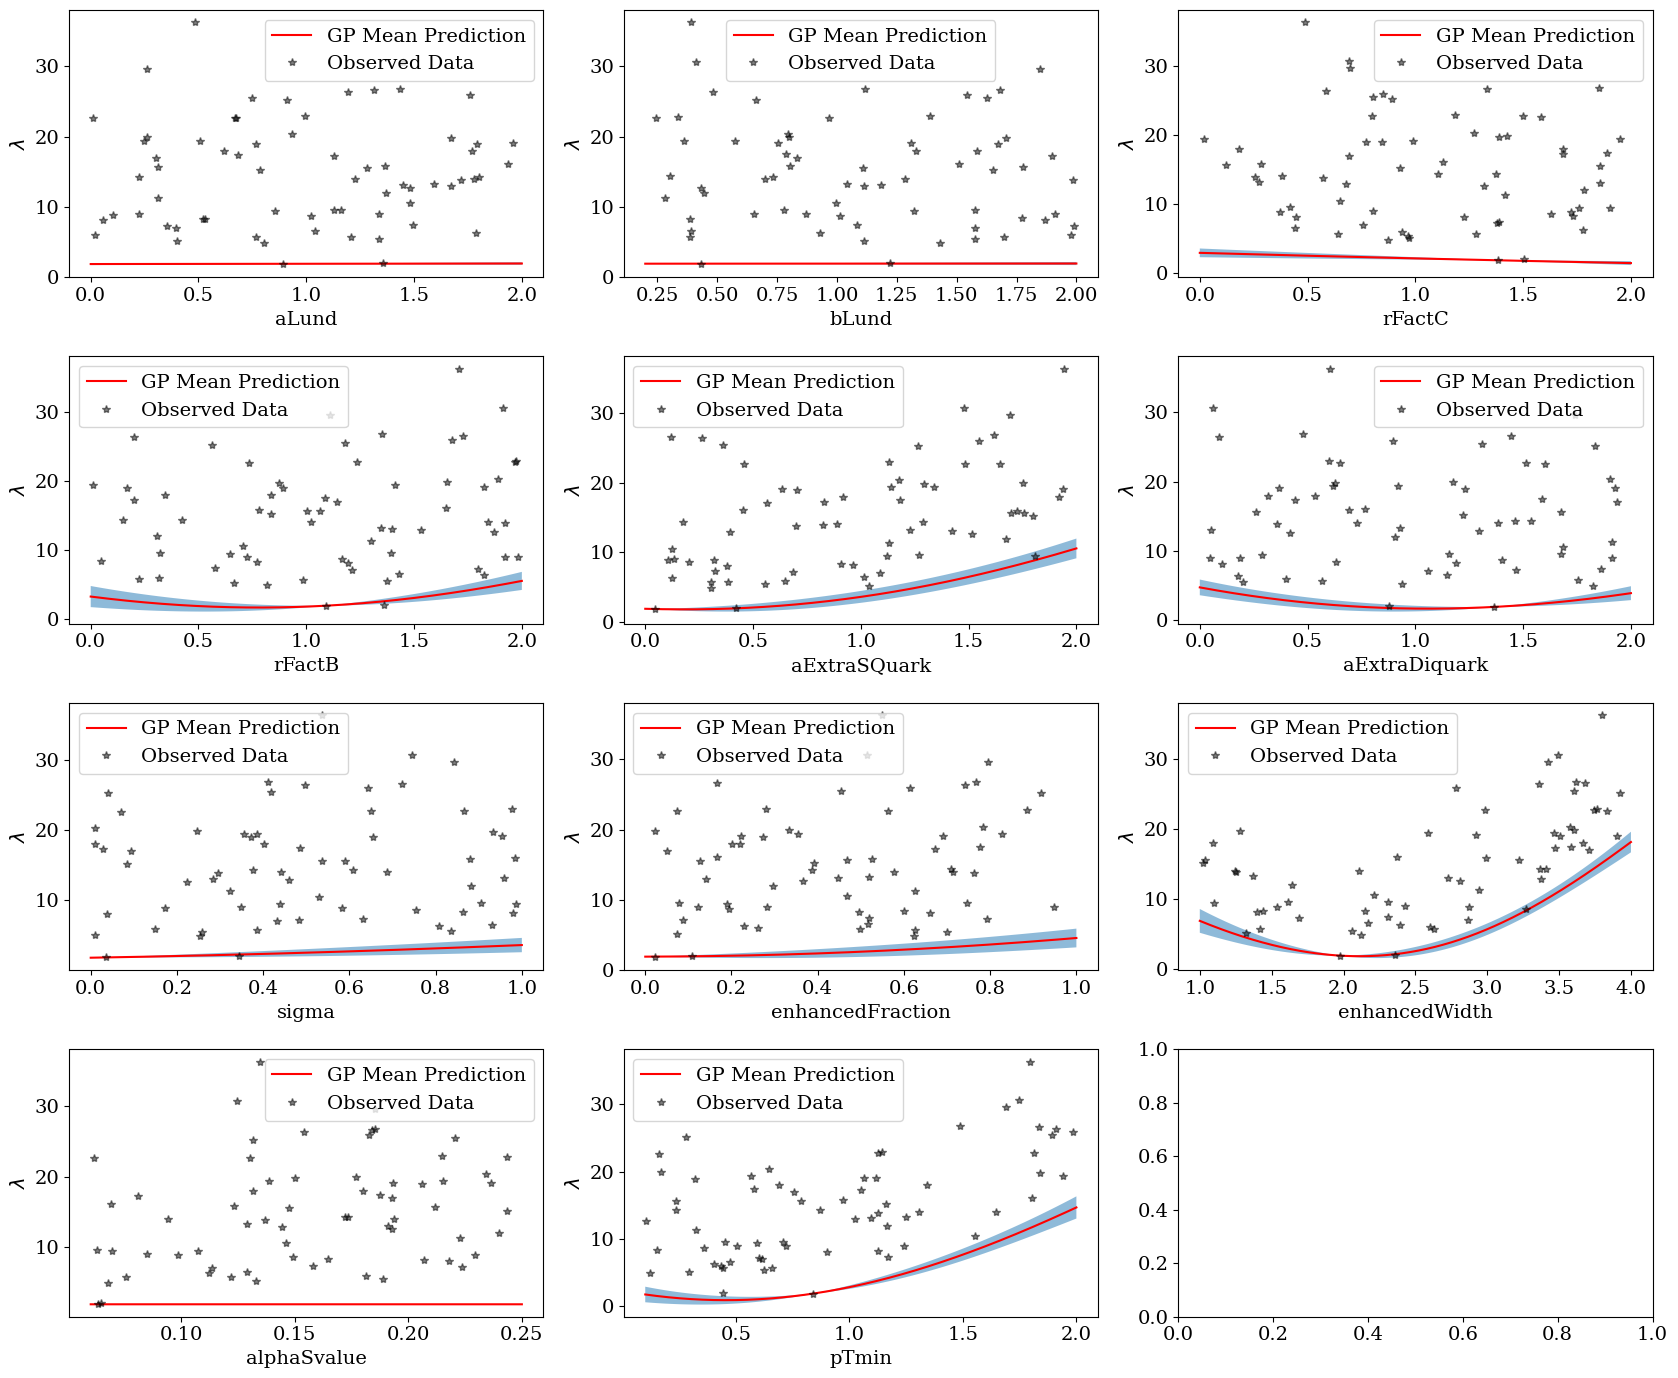

In [42]:
plot_all()

# Perform Bayesian Optimization

In [55]:
n_BO_iterations = 35# num_params * 30

iterations, Matern_EI_LBFGSB_20_restarts = BayesOpt_all_params(model=model,
                    train_x=train_x,
                    train_y=train_y,
                    n_iterations=n_BO_iterations,
                    acquisition = 'EI',
                    retrain_gp=False,
                    print_=False,
                   save_model=False,
                    OPTIMIZE_ACQ=True,
                    suggest_monash_point=False,
                    n_optimize_acq_iter=100,
                    n_restarts=10,
                    minimize_method='Nelder-Mead',
                    jac=None)

iteration 0 next_x = tensor([1.1884e-03, 2.0038e-01, 1.9988e+00, 1.9985e+00, 4.0380e-06, 1.9867e+00,
        8.4319e-03, 0.0000e+00, 1.0004e+00, 2.4933e-01, 1.0000e-01],
       dtype=torch.float64), next_y = tensor([12.3569], dtype=torch.float64)
iteration 1 next_x = tensor([2.0000e+00, 2.0000e+00, 2.0000e+00, 6.4513e-06, 6.6308e-06, 0.0000e+00,
        9.9999e-01, 1.4772e-05, 1.0001e+00, 2.4985e-01, 1.0001e-01],
       dtype=torch.float64), next_y = tensor([13.9377], dtype=torch.float64)
iteration 2 next_x = tensor([1.9971e+00, 1.9873e+00, 8.6648e-04, 1.9942e+00, 7.7897e-05, 1.9995e+00,
        9.9854e-01, 0.0000e+00, 1.3288e+00, 6.0794e-02, 1.0036e-01],
       dtype=torch.float64), next_y = tensor([14.6084], dtype=torch.float64)


KeyboardInterrupt: 

In [ ]:
iterations, Matern_EI_SLSQP_20_restarts =BayesOpt_all_params(model=model,
                    train_x=train_x,
                    train_y=train_y,
                    n_iterations=n_BO_iterations,
                    acquisition = 'EI',
                    retrain_gp=False,
                    print_=False,
                   save_model=False,
                    OPTIMIZE_ACQ=True,
                    suggest_monash_point=False,
                    n_optimize_acq_iter=10,
                    n_restarts=20,
                    minimize_method='SLSQP',
                    jac=None)

iteration 0 next_x = tensor([1.6639, 1.0485, 1.4493, 0.5306, 1.0655, 0.7806, 0.8524, 0.1585, 1.0084,
        0.2356, 0.1574], dtype=torch.float64), next_y = tensor([9.5062], dtype=torch.float64)


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:404: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


iteration 1 next_x = tensor([4.3956e-01, 1.4920e+00, 8.7681e-14, 1.1258e-13, 0.0000e+00, 1.8890e+00,
        1.0000e+00, 0.0000e+00, 1.4423e+00, 1.0553e-01, 1.0000e-01],
       dtype=torch.float64), next_y = tensor([9.9001], dtype=torch.float64)
iteration 2 next_x = tensor([2.0000e+00, 2.0000e-01, 0.0000e+00, 2.0000e+00, 0.0000e+00, 2.0000e+00,
        5.5511e-17, 0.0000e+00, 1.0000e+00, 6.0000e-02, 1.0000e-01],
       dtype=torch.float64), next_y = tensor([15.5430], dtype=torch.float64)
iteration 3 next_x = tensor([1.0368e-12, 2.0000e+00, 2.0000e+00, 0.0000e+00, 7.3277e-13, 1.4943e-12,
        1.0000e+00, 1.4877e-12, 1.5341e+00, 6.0000e-02, 1.0000e-01],
       dtype=torch.float64), next_y = tensor([9.2561], dtype=torch.float64)
iteration 4 next_x = tensor([2.0000, 0.2000, 2.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 1.0242,
        0.2500, 0.1000], dtype=torch.float64), next_y = tensor([13.2150], dtype=torch.float64)
iteration 5 next_x = tensor([1.3600, 1.5512, 1.7029, 1.6775, 0.65

In [ ]:
iterations, Matern_EI_NelderMead_20_restarts =BayesOpt_all_params(model=model,
                    train_x=train_x,
                    train_y=train_y,
                    n_iterations=n_BO_iterations,
                    acquisition = 'EI',
                    retrain_gp=False,
                    print_=False,
                   save_model=False,
                    OPTIMIZE_ACQ=True,
                    suggest_monash_point=False,
                    n_optimize_acq_iter=10,
                    n_restarts=20,
                    minimize_method='Nelder-Mead',
                    jac=None)

iteration 0 next_x = tensor([2.4973e-05, 2.0002e-01, 2.0000e+00, 1.9134e-05, 2.0443e-01, 2.0000e+00,
        1.0000e+00, 2.0828e-05, 1.5722e+00, 2.4986e-01, 1.0000e-01],
       dtype=torch.float64), next_y = tensor([9.0126], dtype=torch.float64)
iteration 1 next_x = tensor([1.6701e+00, 2.0000e+00, 0.0000e+00, 2.2035e-08, 0.0000e+00, 9.9903e-01,
        1.0000e+00, 3.9656e-09, 1.4021e+00, 6.0000e-02, 1.0000e-01],
       dtype=torch.float64), next_y = tensor([9.8821], dtype=torch.float64)
iteration 2 next_x = tensor([2.0000, 0.2000, 0.0000, 0.0000, 0.0000, 2.0000, 0.0000, 0.0000, 1.0000,
        0.2500, 0.1000], dtype=torch.float64), next_y = tensor([14.5770], dtype=torch.float64)
iteration 3 next_x = tensor([9.1124e-05, 2.0000e+00, 8.4560e-03, 4.2824e-04, 8.3046e-04, 0.0000e+00,
        9.9996e-01, 9.9906e-01, 1.2686e+00, 6.0065e-02, 1.0000e-01],
       dtype=torch.float64), next_y = tensor([15.9377], dtype=torch.float64)
iteration 4 next_x = tensor([2.0000, 2.0000, 2.0000, 2.0000, 0.00

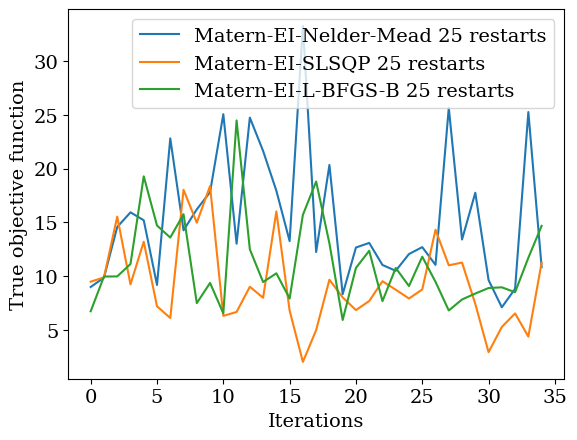

In [ ]:
plt.plot(iterations, Matern_EI_NelderMead_20_restarts, label='Matern-EI-Nelder-Mead 25 restarts')
plt.plot(iterations, Matern_EI_SLSQP_20_restarts, label='Matern-EI-SLSQP 25 restarts')
plt.plot(iterations, Matern_EI_LBFGSB_20_restarts, label='Matern-EI-L-BFGS-B 25 restarts')

plt.xlabel('Iterations')
plt.ylabel('True objective function')
plt.legend()

In [ ]:
MONASH_DICT

{'aLund': 0.68,
 'bLund': 0.98,
 'rFactC': 1.32,
 'rFactB': 0.855,
 'aExtraSQuark': 0.0,
 'aExtraDiquark': 0.97,
 'sigma': 0.335,
 'enhancedFraction': 0.01,
 'enhancedWidth': 2.0,
 'alphaSvalue': 0.1365,
 'pTmin': 0.5}

In [ ]:
POINT2

{'aLund': 0.34,
 'bLund': 0.49,
 'rFactC': 0.66,
 'rFactB': 0.4275,
 'aExtraSQuark': 0.0,
 'aExtraDiquark': 0.485,
 'sigma': 0.1675,
 'enhancedFraction': 0.005,
 'enhancedWidth': 1.0,
 'alphaSvalue': 0.06825,
 'pTmin': 0.25}

In [ ]:
POINT3

{'aLund': 1.02,
 'bLund': 1.47,
 'rFactC': 1.98,
 'rFactB': 1.2825,
 'aExtraSQuark': 0.0,
 'aExtraDiquark': 1.455,
 'sigma': 0.5025000000000001,
 'enhancedFraction': 0.015,
 'enhancedWidth': 3.0,
 'alphaSvalue': 0.20475000000000002,
 'pTmin': 0.75}

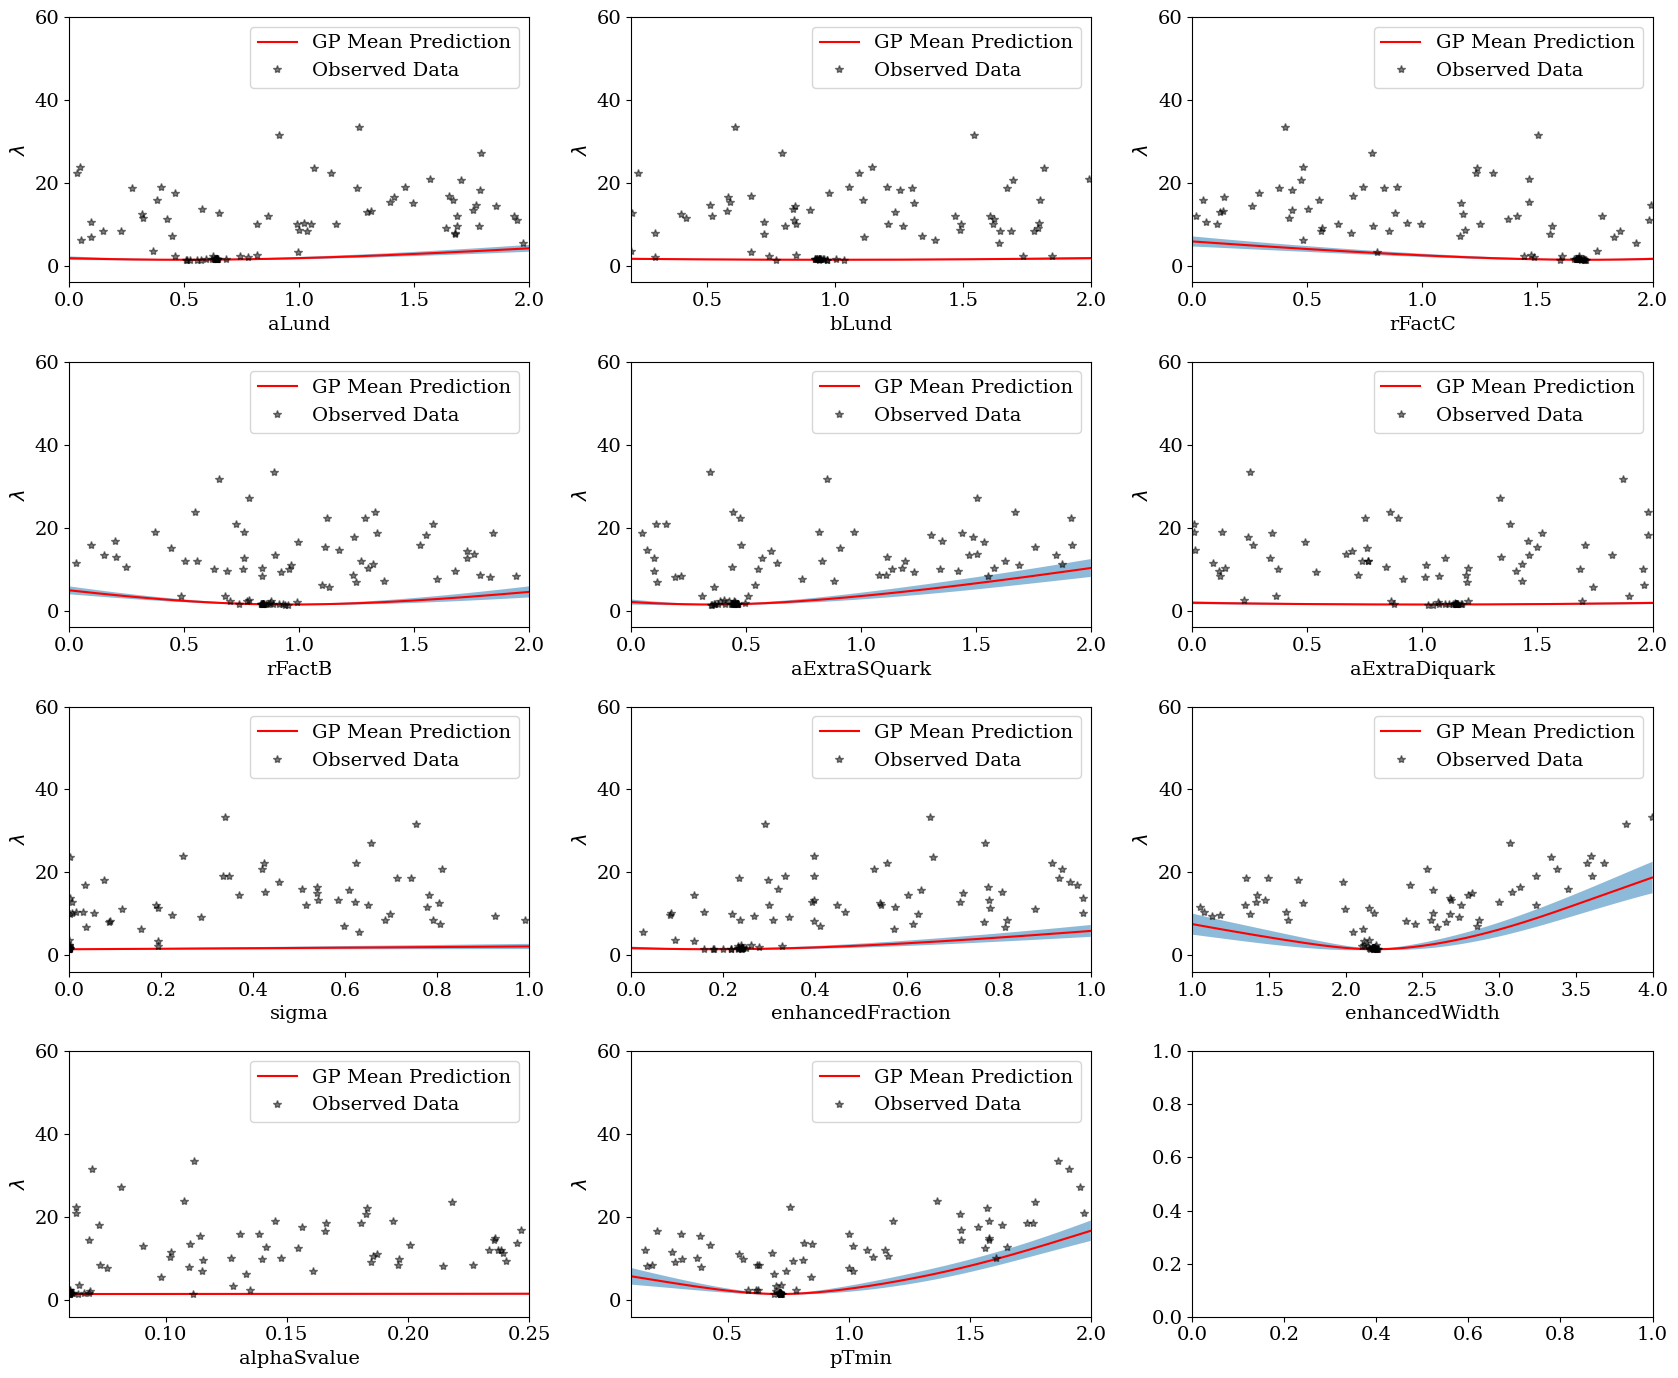

In [ ]:
plot_all(set_xy_lim=True)

In [ ]:
get_observed_best_parameters(model)

{'aLund': 0.5078642077271045,
 'bLund': 0.9661365593491693,
 'rFactC': 1.7090640444775058,
 'rFactB': 0.9514935192651395,
 'aExtraSQuark': 0.347904900616975,
 'aExtraDiquark': 1.0236554123705996,
 'sigma': 1.0086501767203041e-05,
 'enhancedFraction': 0.1794436684898203,
 'enhancedWidth': 2.197183403895365,
 'alphaSvalue': 0.06,
 'pTmin': 0.716367365435306}

-----

# Using BoTorch

In [ ]:
! pip3 install ax-platform

In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import qmc
from scipy.optimize import minimize

import torch

import matplotlib.pyplot as plt
FONTSIZE = 14
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : FONTSIZE}
import matplotlib as mp
mp.rc('font', **font)

# set usetex = False if LaTex is not
# available on your system or if the
# rendering is too slow
mp.rc('text', usetex=False)



from ax.service.ax_client import AxClient, ObjectiveProperties
from ax.utils.measurement.synthetic_functions import hartmann6
from ax.utils.notebook.plotting import init_notebook_plotting, render
from ax.core.observation import ObservationFeatures

from ax.service.ax_client import AxClient, ObjectiveProperties
from ax.utils.measurement.synthetic_functions import hartmann6
from ax.utils.notebook.plotting import init_notebook_plotting, render
from ax.core.observation import ObservationFeatures


from typing import Optional
import botorch
botorch.settings.debug.on()
from botorch.models.gpytorch import GPyTorchModel
from gpytorch.distributions import MultivariateNormal
from gpytorch.kernels import RBFKernel, ScaleKernel
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.means import ConstantMean
from gpytorch.models import ExactGP
from torch import Tensor

from ax.modelbridge.generation_strategy import GenerationStep, GenerationStrategy
from ax.models.torch.botorch_modular.surrogate import Surrogate

from ax.modelbridge.registry import Models
from ax.models.torch.botorch_modular.model import BoTorchModel
from ax.models.torch.botorch_modular.surrogate import Surrogate

from botorch.acquisition.monte_carlo import (
    qExpectedImprovement,
    qNoisyExpectedImprovement,
)
from botorch.acquisition.analytic import ExpectedImprovement
from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood


In [ ]:
# see https://docs.gpytorch.ai/en/v1.11/models.html
class SimpleCustomGP(ExactGP, GPyTorchModel):

    _num_outputs = 1  # to inform GPyTorchModel API

    def __init__(self, train_X, train_Y, train_Yvar: Optional[Tensor] = None):
        # NOTE: This ignores train_Yvar and uses inferred noise instead.
        # squeeze output dim before passing train_Y to ExactGP
        super().__init__(train_X, train_Y.squeeze(-1), GaussianLikelihood())
        self.mean_module = ConstantMean()
        self.covar_module = ScaleKernel(
            # base_kernel=RBFKernel(ard_num_dims=train_X.shape[-1]),
            base_kernel=MaternKernel(ard_num_dims=train_X.shape[-1])
        )
        self.to(train_X)  # make sure we're on the right device/dtype

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return MultivariateNormal(mean_x, covar_x)

In [ ]:
ax_model = BoTorchModel(
    surrogate=Surrogate(
        # The model class to use
        botorch_model_class=SimpleCustomGP,
        # Optional, MLL class with which to optimize model parameters
        mll_class=ExactMarginalLogLikelihood,
        # Optional, dictionary of keyword arguments to model constructor
        # model_options={}
    ),
    # Optional, acquisition function class to use - see custom acquisition tutorial
    # botorch_acqf_class=qExpectedImprovement,
    botorch_acqf_class=ExpectedImprovement
)

In [ ]:
from ax.modelbridge.generation_strategy import GenerationStep, GenerationStrategy
from ax.models.torch.botorch_modular.surrogate import Surrogate

from ax.modelbridge.registry import Models


gs = GenerationStrategy(
    steps=[
        # Quasi-random initialization step
        GenerationStep(
            model=Models.SOBOL,
            num_trials=20,  # How many trials should be produced from this generation step
        ),
        # Bayesian optimization step using the custom acquisition function
        GenerationStep(
            model=Models.BOTORCH_MODULAR,
            num_trials=-1,  # No limitation on how many trials should be produced from this step
            # For `BOTORCH_MODULAR`, we pass in kwargs to specify what surrogate or acquisition function to use.
            model_kwargs={
                "surrogate": Surrogate(SimpleCustomGP),
            },
        ),
    ]
)


In [ ]:
ax_client = AxClient()
ax_client.create_experiment(
name="Ax_Tune_Pythia",
        parameters = [
                    {
                        "name": "aLund",
                        "type": "range",
                        "bounds": [0.5, 2.0],
                    },
                    {
                        "name": "bLund",
                        "type": "range",
                        "bounds": [0.5, 2.0],
                    },
                    {
                        "name": "rFactC",
                        "type": "range",
                        "bounds": [0.0, 2.0],
                    },
                    {
                        "name": "rFactB",
                        "type": "range",
                        "bounds": [0.0, 2.0],
                    },
                    {
                        "name": "aExtraSQuark",
                        "type": "range",
                        "bounds": [0.0, 2.0],
                    },
                    {
                        "name": "aExtraDiquark",
                        "type": "range",
                        "bounds": [0.0, 2.0],
                    },
                    {
                        "name": "sigma",
                        "type": "range",
                        "bounds": [0.,1.],
                    },
                    {
                        "name": "enhancedFraction",
                        "type": "range",
                        "bounds": [0.,1.],
                    },
                    {
                        "name": "enhancedWidth",
                        "type": "range",
                        "bounds": [1.0,4.0],
                    },
                    # {
                    #     "name": "ProbStoUD",
                    #     "type": "range",
                    #     "value_type": "float",
                    #     "bounds": [0,4.0],
                    # },
                    # {
                    #     "name": "probQQtoQ",
                    #     "type": "range",
                    #     "value_type": "float",
                    #     "bounds": [0,4.0],
                    # },
                    # {
                    #     "name": "probSQtoQQ",
                    #     "type": "range",
                    #     "value_type": "float",
                    #     "bounds": [0,4.0],
                    # },
                    # {
                    #     "name": "ProbQQ1toQQ0",
                    #     "type": "range",
                    #     "value_type": "float",
                    #     "bounds": [0,4.0],
                    # },
                    {
                        "name": "alphaSvalue",
                        "type": "range",
                        "value_type": "float",
                        "bounds": [0.06,0.25],
                    },
                    {
                        "name": "pTmin",
                        "type": "range",
                        "value_type": "float",
                        "bounds": [0.1,2.0],
                    },

                ],
objectives = {"true_objective_func": ObjectiveProperties(minimize=True)},
)

[INFO 07-15 22:13:50] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 6 decimal points.
[INFO 07-15 22:13:50] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter aLund. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 07-15 22:13:50] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter bLund. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 07-15 22:13:50] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter rFactC. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 07-15 22:13:50] a

In [ ]:
##########################################
# Sample Monash Tune point
# suggest_param, suggest_ind = ax_client.attach_trial(
#     parameters=MONASH_DICT
# )
# ax_client.complete_trial(trial_index=suggest_ind, raw_data=true_objective_func(
#         aLund=suggest_param["aLund"],
#         bLund=suggest_param["bLund"],
#         # rFactC=suggest_param["rFactC"],
#         # rFactB=suggest_param["rFactB"],
#         # aExtraSQuark=suggest_param["aExtraSQuark"],
#         # aExtraDiquark=suggest_param["aExtraDiquark"],
#         # sigma=suggest_param["sigma"],
#         # enhancedFraction=suggest_param["enhancedFraction"],
#         # enhancedWidth=suggest_param["enhancedWidth"],
#         # ProbStoUD=suggest_param["ProbStoUD"],
#         # probQQtoQ=suggest_param["probQQtoQ"],
#         # probSQtoQQ=suggest_param["probSQtoQQ"],
#         # ProbQQ1toQQ0=suggest_param["ProbQQ1toQQ0"],
#         # alphaSvalue=suggest_param["alphaSvalue"],
#         # pTmin=suggest_param["pTmin"]
# ))


##########################################
# start main tuning loop
N_ITER = 80
for i in range(N_ITER):
    parameterization, trial_index = ax_client.get_next_trial()
    print(parameterization)
    trial = ax_client.complete_trial(trial_index=trial_index, raw_data=true_objective_func(
        aLund=parameterization["aLund"],
        bLund=parameterization["bLund"],
        rFactC=parameterization["rFactC"],
        rFactB=parameterization["rFactB"],
        aExtraSQuark=parameterization["aExtraSQuark"],
        aExtraDiquark=parameterization["aExtraDiquark"],
        sigma=parameterization["sigma"],
        enhancedFraction=parameterization["enhancedFraction"],
        enhancedWidth=parameterization["enhancedWidth"],
        # ProbStoUD=parameterization["ProbStoUD"],
        # probQQtoQ=parameterization["probQQtoQ"],
        # probSQtoQQ=parameterization["probSQtoQQ"],
        # ProbQQ1toQQ0=parameterization["ProbQQ1toQQ0"],
        alphaSvalue=parameterization["alphaSvalue"],
        pTmin=parameterization["pTmin"]
    ))



[INFO 07-15 22:13:52] ax.service.ax_client: Generated new trial 0 with parameters {'aLund': 0.604905, 'bLund': 1.347555, 'rFactC': 0.274676, 'rFactB': 0.620897, 'aExtraSQuark': 1.90614, 'aExtraDiquark': 1.043548, 'sigma': 0.544495, 'enhancedFraction': 0.081045, 'enhancedWidth': 3.209267, 'alphaSvalue': 0.096326, 'pTmin': 1.62594} using model Sobol.
[INFO 07-15 22:13:52] ax.service.ax_client: Completed trial 0 with data: {'true_objective_func': (107.832088, None)}.
[INFO 07-15 22:13:52] ax.service.ax_client: Generated new trial 1 with parameters {'aLund': 1.871861, 'bLund': 1.846868, 'rFactC': 1.406887, 'rFactB': 0.841431, 'aExtraSQuark': 1.02578, 'aExtraDiquark': 0.674465, 'sigma': 0.03785, 'enhancedFraction': 0.713773, 'enhancedWidth': 3.849786, 'alphaSvalue': 0.190076, 'pTmin': 1.791867} using model Sobol.
[INFO 07-15 22:13:52] ax.service.ax_client: Completed trial 1 with data: {'true_objective_func': (156.277568, None)}.
[INFO 07-15 22:13:52] ax.service.ax_client: Generated new tria

{'aLund': 0.6049045026302338, 'bLund': 1.3475548028945923, 'rFactC': 0.2746758460998535, 'rFactB': 0.6208971738815308, 'aExtraSQuark': 1.9061403274536133, 'aExtraDiquark': 1.0435478687286377, 'sigma': 0.5444952249526978, 'enhancedFraction': 0.08104506134986877, 'enhancedWidth': 3.2092670798301697, 'alphaSvalue': 0.09632555723190307, 'pTmin': 1.6259400367736816}
{'aLund': 1.8718608603812754, 'bLund': 1.8468679543584585, 'rFactC': 1.4068871606141329, 'rFactB': 0.8414307851344347, 'aExtraSQuark': 1.0257795676589012, 'aExtraDiquark': 0.6744652166962624, 'sigma': 0.03785047587007284, 'enhancedFraction': 0.7137726377695799, 'enhancedWidth': 3.8497864548116922, 'alphaSvalue': 0.19007579592987894, 'pTmin': 1.7918670412153006}
{'aLund': 1.37954939622432, 'bLund': 0.8515862934291363, 'rFactC': 0.0563050489872694, 'rFactB': 0.5492640379816294, 'aExtraSQuark': 0.3014001529663801, 'aExtraDiquark': 0.7218347731977701, 'sigma': 0.48757442459464073, 'enhancedFraction': 0.7589321807026863, 'enhancedWid

[INFO 07-15 22:13:52] ax.service.ax_client: Completed trial 5 with data: {'true_objective_func': (54.129489, None)}.
[INFO 07-15 22:13:52] ax.service.ax_client: Generated new trial 6 with parameters {'aLund': 1.645457, 'bLund': 1.353761, 'rFactC': 0.757781, 'rFactB': 0.774307, 'aExtraSQuark': 1.116122, 'aExtraDiquark': 1.340355, 'sigma': 0.337671, 'enhancedFraction': 0.535809, 'enhancedWidth': 3.503133, 'alphaSvalue': 0.090095, 'pTmin': 1.047135} using model Sobol.
[INFO 07-15 22:13:52] ax.service.ax_client: Completed trial 6 with data: {'true_objective_func': (60.290351, None)}.
[INFO 07-15 22:13:52] ax.service.ax_client: Generated new trial 7 with parameters {'aLund': 1.985171, 'bLund': 0.799905, 'rFactC': 0.656536, 'rFactB': 0.189418, 'aExtraSQuark': 0.596056, 'aExtraDiquark': 1.391166, 'sigma': 0.804921, 'enhancedFraction': 0.793881, 'enhancedWidth': 2.098594, 'alphaSvalue': 0.217013, 'pTmin': 1.750618} using model Sobol.
[INFO 07-15 22:13:52] ax.service.ax_client: Completed trial 

{'aLund': 1.6454570977948606, 'bLund': 1.353760540485382, 'rFactC': 0.7577809430658817, 'rFactB': 0.7743069604039192, 'aExtraSQuark': 1.116122318431735, 'aExtraDiquark': 1.3403548020869493, 'sigma': 0.3376708012074232, 'enhancedFraction': 0.5358092533424497, 'enhancedWidth': 3.5031327605247498, 'alphaSvalue': 0.09009472738020122, 'pTmin': 1.0471345375292003}
{'aLund': 1.9851712342351675, 'bLund': 0.7999045052565634, 'rFactC': 0.6565361954271793, 'rFactB': 0.18941782973706722, 'aExtraSQuark': 0.5960559360682964, 'aExtraDiquark': 1.39116632938385, 'sigma': 0.8049211800098419, 'enhancedFraction': 0.7938805008307099, 'enhancedWidth': 2.0985939651727676, 'alphaSvalue': 0.21701319579035044, 'pTmin': 1.750618188083172}
{'aLund': 1.0072530657052994, 'bLund': 1.4456354095600545, 'rFactC': 0.13127060793340206, 'rFactB': 1.064692659303546, 'aExtraSQuark': 0.9093039818108082, 'aExtraDiquark': 0.947388369590044, 'sigma': 0.5721159065142274, 'enhancedFraction': 0.35988710075616837, 'enhancedWidth': 

[INFO 07-15 22:13:52] ax.service.ax_client: Generated new trial 12 with parameters {'aLund': 1.79955, 'bLund': 1.870688, 'rFactC': 0.992929, 'rFactB': 0.300813, 'aExtraSQuark': 1.468356, 'aExtraDiquark': 0.353959, 'sigma': 0.007011, 'enhancedFraction': 0.837816, 'enhancedWidth': 3.714215, 'alphaSvalue': 0.094078, 'pTmin': 1.610461} using model Sobol.
[INFO 07-15 22:13:52] ax.service.ax_client: Completed trial 12 with data: {'true_objective_func': (159.627342, None)}.
[INFO 07-15 22:13:52] ax.service.ax_client: Generated new trial 13 with parameters {'aLund': 1.528922, 'bLund': 0.906167, 'rFactC': 0.475027, 'rFactB': 0.035616, 'aExtraSQuark': 1.115659, 'aExtraDiquark': 1.6441, 'sigma': 0.46329, 'enhancedFraction': 0.72243, 'enhancedWidth': 1.765079, 'alphaSvalue': 0.18208, 'pTmin': 0.170363} using model Sobol.
[INFO 07-15 22:13:52] ax.service.ax_client: Completed trial 13 with data: {'true_objective_func': (38.638722, None)}.
[INFO 07-15 22:13:52] ax.service.ax_client: Generated new tri

{'aLund': 1.7995496997609735, 'bLund': 1.8706877320073545, 'rFactC': 0.9929288066923618, 'rFactB': 0.30081270448863506, 'aExtraSQuark': 1.4683559779077768, 'aExtraDiquark': 0.3539585489779711, 'sigma': 0.007010601460933685, 'enhancedFraction': 0.8378160912543535, 'enhancedWidth': 3.714214574545622, 'alphaSvalue': 0.09407770837657153, 'pTmin': 1.6104609803296626}
{'aLund': 1.5289219082333148, 'bLund': 0.9061669236980379, 'rFactC': 0.475027097389102, 'rFactB': 0.03561555594205856, 'aExtraSQuark': 1.1156587842851877, 'aExtraDiquark': 1.6441003065556288, 'sigma': 0.4632898857817054, 'enhancedFraction': 0.7224299879744649, 'enhancedWidth': 1.765078702941537, 'alphaSvalue': 0.18207969081588088, 'pTmin': 0.1703626275062561}
{'aLund': 1.0118200588040054, 'bLund': 1.0240526222623885, 'rFactC': 0.5186519213020802, 'rFactB': 1.4788270350545645, 'aExtraSQuark': 1.8638914916664362, 'aExtraDiquark': 1.7408174946904182, 'sigma': 0.8198966523632407, 'enhancedFraction': 0.1428805384784937, 'enhancedWid

[INFO 07-15 22:13:52] ax.service.ax_client: Generated new trial 19 with parameters {'aLund': 0.948225, 'bLund': 0.633711, 'rFactC': 0.309805, 'rFactB': 0.061901, 'aExtraSQuark': 1.767663, 'aExtraDiquark': 0.149693, 'sigma': 0.23463, 'enhancedFraction': 0.426844, 'enhancedWidth': 2.627139, 'alphaSvalue': 0.126054, 'pTmin': 1.038494} using model Sobol.
[INFO 07-15 22:13:52] ax.service.ax_client: Completed trial 19 with data: {'true_objective_func': (64.901977, None)}.
[INFO 07-15 22:13:52] ax.service.ax_client: Generated new trial 20 with parameters {'aLund': 1.787446, 'bLund': 0.765151, 'rFactC': 1.539879, 'rFactB': 0.255637, 'aExtraSQuark': 1.732315, 'aExtraDiquark': 1.540658, 'sigma': 0.252123, 'enhancedFraction': 0.306475, 'enhancedWidth': 2.5361, 'alphaSvalue': 0.077713, 'pTmin': 0.510296} using model Sobol.
[INFO 07-15 22:13:52] ax.service.ax_client: Completed trial 20 with data: {'true_objective_func': (35.745256, None)}.
[INFO 07-15 22:13:53] ax.service.ax_client: Generated new t

{'aLund': 0.9482253342866898, 'bLund': 0.6337111187167466, 'rFactC': 0.30980547331273556, 'rFactB': 0.06190149672329426, 'aExtraSQuark': 1.7676630597561598, 'aExtraDiquark': 0.1496925801038742, 'sigma': 0.23463001754134893, 'enhancedFraction': 0.42684449814260006, 'enhancedWidth': 2.6271389005705714, 'alphaSvalue': 0.12605436774902046, 'pTmin': 1.038494420144707}
{'aLund': 1.7874463950283825, 'bLund': 0.7651511048898101, 'rFactC': 1.5398789830505848, 'rFactB': 0.2556365504860878, 'aExtraSQuark': 1.7323149051517248, 'aExtraDiquark': 1.5406581796705723, 'sigma': 0.2521231872960925, 'enhancedFraction': 0.30647531524300575, 'enhancedWidth': 2.53610020596534, 'alphaSvalue': 0.07771254021674394, 'pTmin': 0.5102961827069521}
{'aLund': 0.8166075958870351, 'bLund': 1.5373070021159947, 'rFactC': 1.3621037565171719, 'rFactB': 0.8060600180178881, 'aExtraSQuark': 1.8547863233834505, 'aExtraDiquark': 1.9448298271745443, 'sigma': 0.923668596893549, 'enhancedFraction': 0.6117572858929634, 'enhancedWid

[INFO 07-15 22:13:54] ax.service.ax_client: Generated new trial 22 with parameters {'aLund': 1.844697, 'bLund': 1.09526, 'rFactC': 1.539278, 'rFactB': 0.318164, 'aExtraSQuark': 0.821025, 'aExtraDiquark': 0.918399, 'sigma': 0.715192, 'enhancedFraction': 0.301607, 'enhancedWidth': 2.590393, 'alphaSvalue': 0.191656, 'pTmin': 0.543351} using model BoTorch.
[INFO 07-15 22:13:54] ax.service.ax_client: Completed trial 22 with data: {'true_objective_func': (14.091968, None)}.


{'aLund': 1.8446967605612081, 'bLund': 1.0952595621395798, 'rFactC': 1.5392780736476797, 'rFactB': 0.3181643538291984, 'aExtraSQuark': 0.8210245828229299, 'aExtraDiquark': 0.9183987724171122, 'sigma': 0.7151918305109134, 'enhancedFraction': 0.3016071689575907, 'enhancedWidth': 2.590393174176339, 'alphaSvalue': 0.19165597335273837, 'pTmin': 0.5433513482612984}


[INFO 07-15 22:13:55] ax.service.ax_client: Generated new trial 23 with parameters {'aLund': 1.385389, 'bLund': 1.240803, 'rFactC': 0.75996, 'rFactB': 0.708616, 'aExtraSQuark': 0.989279, 'aExtraDiquark': 1.029847, 'sigma': 0.577862, 'enhancedFraction': 0.368793, 'enhancedWidth': 2.492585, 'alphaSvalue': 0.134685, 'pTmin': 0.508671} using model BoTorch.
[INFO 07-15 22:13:55] ax.service.ax_client: Completed trial 23 with data: {'true_objective_func': (12.447521, None)}.


{'aLund': 1.3853885971363515, 'bLund': 1.2408034576323408, 'rFactC': 0.7599603529344191, 'rFactB': 0.7086158740861829, 'aExtraSQuark': 0.9892792569800151, 'aExtraDiquark': 1.0298470276684677, 'sigma': 0.5778617019243125, 'enhancedFraction': 0.3687929456808665, 'enhancedWidth': 2.4925850401402934, 'alphaSvalue': 0.1346852468975569, 'pTmin': 0.508671127141783}


[INFO 07-15 22:13:56] ax.service.ax_client: Generated new trial 24 with parameters {'aLund': 1.570882, 'bLund': 1.27359, 'rFactC': 1.148656, 'rFactB': 0.657323, 'aExtraSQuark': 0.747046, 'aExtraDiquark': 0.821023, 'sigma': 0.735949, 'enhancedFraction': 0.300119, 'enhancedWidth': 2.620882, 'alphaSvalue': 0.168048, 'pTmin': 0.620806} using model BoTorch.
[INFO 07-15 22:13:56] ax.service.ax_client: Completed trial 24 with data: {'true_objective_func': (11.080944, None)}.


{'aLund': 1.5708824103931953, 'bLund': 1.273589843883376, 'rFactC': 1.1486561657750345, 'rFactB': 0.6573233646388936, 'aExtraSQuark': 0.7470462731239408, 'aExtraDiquark': 0.8210229419400101, 'sigma': 0.7359487239430382, 'enhancedFraction': 0.3001185694582371, 'enhancedWidth': 2.6208823034148505, 'alphaSvalue': 0.16804784433570757, 'pTmin': 0.6208056659815723}


[INFO 07-15 22:13:57] ax.service.ax_client: Generated new trial 25 with parameters {'aLund': 1.501519, 'bLund': 1.312217, 'rFactC': 1.392496, 'rFactB': 0.589342, 'aExtraSQuark': 0.976161, 'aExtraDiquark': 1.002864, 'sigma': 0.719574, 'enhancedFraction': 0.451762, 'enhancedWidth': 2.403836, 'alphaSvalue': 0.144871, 'pTmin': 0.587186} using model BoTorch.
[INFO 07-15 22:13:57] ax.service.ax_client: Completed trial 25 with data: {'true_objective_func': (12.024062, None)}.


{'aLund': 1.5015188766198881, 'bLund': 1.312216628313766, 'rFactC': 1.3924958376333563, 'rFactB': 0.5893418333704611, 'aExtraSQuark': 0.9761611099674596, 'aExtraDiquark': 1.002863981315901, 'sigma': 0.719574175072328, 'enhancedFraction': 0.45176249605206603, 'enhancedWidth': 2.4038359965183487, 'alphaSvalue': 0.14487141184468044, 'pTmin': 0.5871856452913671}


[INFO 07-15 22:13:59] ax.service.ax_client: Generated new trial 26 with parameters {'aLund': 1.643402, 'bLund': 1.202089, 'rFactC': 1.317133, 'rFactB': 0.745882, 'aExtraSQuark': 1.039761, 'aExtraDiquark': 1.043278, 'sigma': 0.601236, 'enhancedFraction': 0.244868, 'enhancedWidth': 2.491582, 'alphaSvalue': 0.146423, 'pTmin': 0.663382} using model BoTorch.
[INFO 07-15 22:13:59] ax.service.ax_client: Completed trial 26 with data: {'true_objective_func': (11.612783, None)}.


{'aLund': 1.6434016348887404, 'bLund': 1.2020894282510763, 'rFactC': 1.3171331056371738, 'rFactB': 0.7458822473842022, 'aExtraSQuark': 1.0397608772250195, 'aExtraDiquark': 1.0432782741901823, 'sigma': 0.6012355852708072, 'enhancedFraction': 0.24486770572274913, 'enhancedWidth': 2.491582310740174, 'alphaSvalue': 0.14642293115444965, 'pTmin': 0.6633815593573031}


[INFO 07-15 22:14:01] ax.service.ax_client: Generated new trial 27 with parameters {'aLund': 1.551137, 'bLund': 1.18615, 'rFactC': 0.962507, 'rFactB': 0.530524, 'aExtraSQuark': 0.871172, 'aExtraDiquark': 1.142376, 'sigma': 0.644021, 'enhancedFraction': 0.383518, 'enhancedWidth': 2.331009, 'alphaSvalue': 0.176443, 'pTmin': 0.758292} using model BoTorch.
[INFO 07-15 22:14:01] ax.service.ax_client: Completed trial 27 with data: {'true_objective_func': (11.508462, None)}.


{'aLund': 1.551137087780981, 'bLund': 1.186149518689853, 'rFactC': 0.9625072351963491, 'rFactB': 0.5305241868287687, 'aExtraSQuark': 0.8711722967527599, 'aExtraDiquark': 1.1423763428239442, 'sigma': 0.6440209828205515, 'enhancedFraction': 0.3835182239778333, 'enhancedWidth': 2.3310087127817725, 'alphaSvalue': 0.17644272849372797, 'pTmin': 0.7582916394700917}


[INFO 07-15 22:14:04] ax.service.ax_client: Generated new trial 28 with parameters {'aLund': 1.358641, 'bLund': 1.397784, 'rFactC': 0.814052, 'rFactB': 1.021151, 'aExtraSQuark': 0.838518, 'aExtraDiquark': 1.057981, 'sigma': 0.66099, 'enhancedFraction': 0.400546, 'enhancedWidth': 2.319046, 'alphaSvalue': 0.121075, 'pTmin': 0.730951} using model BoTorch.
[INFO 07-15 22:14:04] ax.service.ax_client: Completed trial 28 with data: {'true_objective_func': (10.397575, None)}.


{'aLund': 1.3586406152528516, 'bLund': 1.3977837546673944, 'rFactC': 0.8140515956179202, 'rFactB': 1.0211511116007195, 'aExtraSQuark': 0.8385181455025648, 'aExtraDiquark': 1.0579806743050093, 'sigma': 0.6609899154767325, 'enhancedFraction': 0.4005458650637495, 'enhancedWidth': 2.3190457425276465, 'alphaSvalue': 0.12107526533214089, 'pTmin': 0.7309505956915168}


[INFO 07-15 22:14:07] ax.service.ax_client: Generated new trial 29 with parameters {'aLund': 1.756177, 'bLund': 1.201982, 'rFactC': 0.836151, 'rFactB': 0.707354, 'aExtraSQuark': 0.957678, 'aExtraDiquark': 0.937819, 'sigma': 0.750268, 'enhancedFraction': 0.394107, 'enhancedWidth': 2.401896, 'alphaSvalue': 0.124051, 'pTmin': 0.694131} using model BoTorch.
[INFO 07-15 22:14:07] ax.service.ax_client: Completed trial 29 with data: {'true_objective_func': (14.842397, None)}.


{'aLund': 1.756176581146228, 'bLund': 1.201982280318561, 'rFactC': 0.8361507147492175, 'rFactB': 0.7073537720829977, 'aExtraSQuark': 0.957678174171643, 'aExtraDiquark': 0.937819430018113, 'sigma': 0.750267537911523, 'enhancedFraction': 0.3941071827639783, 'enhancedWidth': 2.4018960931340523, 'alphaSvalue': 0.12405119691275428, 'pTmin': 0.6941305953468632}


[INFO 07-15 22:14:10] ax.service.ax_client: Generated new trial 30 with parameters {'aLund': 1.419331, 'bLund': 1.256433, 'rFactC': 1.1519, 'rFactB': 0.5302, 'aExtraSQuark': 0.639026, 'aExtraDiquark': 1.029749, 'sigma': 0.565943, 'enhancedFraction': 0.324503, 'enhancedWidth': 2.406843, 'alphaSvalue': 0.115618, 'pTmin': 0.708775} using model BoTorch.
[INFO 07-15 22:14:10] ax.service.ax_client: Completed trial 30 with data: {'true_objective_func': (7.168724, None)}.


{'aLund': 1.419330645032009, 'bLund': 1.2564332464861176, 'rFactC': 1.1518999542441142, 'rFactB': 0.5302002787415544, 'aExtraSQuark': 0.6390261426394155, 'aExtraDiquark': 1.02974874377955, 'sigma': 0.5659429477480462, 'enhancedFraction': 0.3245027578303139, 'enhancedWidth': 2.406842898379988, 'alphaSvalue': 0.11561836257585406, 'pTmin': 0.7087746982524354}


[INFO 07-15 22:14:11] ax.service.ax_client: Generated new trial 31 with parameters {'aLund': 1.555778, 'bLund': 1.511027, 'rFactC': 0.9474, 'rFactB': 0.502739, 'aExtraSQuark': 0.7696, 'aExtraDiquark': 1.200485, 'sigma': 0.581562, 'enhancedFraction': 0.296784, 'enhancedWidth': 2.449044, 'alphaSvalue': 0.131974, 'pTmin': 0.667265} using model BoTorch.
[INFO 07-15 22:14:11] ax.service.ax_client: Completed trial 31 with data: {'true_objective_func': (10.484568, None)}.


{'aLund': 1.555777621745503, 'bLund': 1.5110266584479106, 'rFactC': 0.9473997735516761, 'rFactB': 0.5027390102513273, 'aExtraSQuark': 0.7695996729004106, 'aExtraDiquark': 1.2004850378681866, 'sigma': 0.5815616558421467, 'enhancedFraction': 0.29678414779429046, 'enhancedWidth': 2.4490437103245455, 'alphaSvalue': 0.1319737917509522, 'pTmin': 0.6672645662322209}


[INFO 07-15 22:14:13] ax.service.ax_client: Generated new trial 32 with parameters {'aLund': 1.609835, 'bLund': 1.27503, 'rFactC': 1.177266, 'rFactB': 0.803717, 'aExtraSQuark': 0.611993, 'aExtraDiquark': 1.107956, 'sigma': 0.469236, 'enhancedFraction': 0.445351, 'enhancedWidth': 2.515164, 'alphaSvalue': 0.142708, 'pTmin': 0.668894} using model BoTorch.
[INFO 07-15 22:14:13] ax.service.ax_client: Completed trial 32 with data: {'true_objective_func': (8.306842, None)}.


{'aLund': 1.609834921549074, 'bLund': 1.2750298942206535, 'rFactC': 1.177265825041446, 'rFactB': 0.803716668328062, 'aExtraSQuark': 0.6119925701671912, 'aExtraDiquark': 1.1079559412819364, 'sigma': 0.46923621807637744, 'enhancedFraction': 0.44535143430835133, 'enhancedWidth': 2.515164059183297, 'alphaSvalue': 0.14270838538485217, 'pTmin': 0.668894399656605}


[INFO 07-15 22:14:15] ax.service.ax_client: Generated new trial 33 with parameters {'aLund': 1.394575, 'bLund': 1.228104, 'rFactC': 1.120328, 'rFactB': 0.750195, 'aExtraSQuark': 0.689263, 'aExtraDiquark': 1.3634, 'sigma': 0.646266, 'enhancedFraction': 0.368475, 'enhancedWidth': 2.584777, 'alphaSvalue': 0.126294, 'pTmin': 0.689981} using model BoTorch.
[INFO 07-15 22:14:15] ax.service.ax_client: Completed trial 33 with data: {'true_objective_func': (9.532014, None)}.


{'aLund': 1.3945747138322162, 'bLund': 1.2281043227050796, 'rFactC': 1.1203278475115812, 'rFactB': 0.7501947756434905, 'aExtraSQuark': 0.6892632204056464, 'aExtraDiquark': 1.3634002223157229, 'sigma': 0.6462657526614711, 'enhancedFraction': 0.3684745041025818, 'enhancedWidth': 2.584777140811674, 'alphaSvalue': 0.12629415330736504, 'pTmin': 0.6899808215469565}


[INFO 07-15 22:14:17] ax.service.ax_client: Generated new trial 34 with parameters {'aLund': 1.313664, 'bLund': 1.342239, 'rFactC': 1.001816, 'rFactB': 0.671637, 'aExtraSQuark': 0.866265, 'aExtraDiquark': 1.019065, 'sigma': 0.475431, 'enhancedFraction': 0.418464, 'enhancedWidth': 2.569721, 'alphaSvalue': 0.12524, 'pTmin': 0.742063} using model BoTorch.
[INFO 07-15 22:14:17] ax.service.ax_client: Completed trial 34 with data: {'true_objective_func': (11.180902, None)}.


{'aLund': 1.3136644481413302, 'bLund': 1.342239347738377, 'rFactC': 1.0018162577968523, 'rFactB': 0.6716370052577513, 'aExtraSQuark': 0.8662650784820819, 'aExtraDiquark': 1.0190648989994866, 'sigma': 0.4754305020017471, 'enhancedFraction': 0.41846351500290174, 'enhancedWidth': 2.5697211208547275, 'alphaSvalue': 0.12524000057639495, 'pTmin': 0.7420632579170093}


[INFO 07-15 22:14:19] ax.service.ax_client: Generated new trial 35 with parameters {'aLund': 1.523716, 'bLund': 1.269088, 'rFactC': 1.387723, 'rFactB': 0.706433, 'aExtraSQuark': 0.446439, 'aExtraDiquark': 1.109105, 'sigma': 0.606004, 'enhancedFraction': 0.285427, 'enhancedWidth': 2.272358, 'alphaSvalue': 0.163479, 'pTmin': 0.629563} using model BoTorch.
[INFO 07-15 22:14:19] ax.service.ax_client: Completed trial 35 with data: {'true_objective_func': (4.651839, None)}.


{'aLund': 1.5237155030560605, 'bLund': 1.2690881282415347, 'rFactC': 1.3877225567397262, 'rFactB': 0.7064331665563371, 'aExtraSQuark': 0.4464386587114031, 'aExtraDiquark': 1.1091053351076248, 'sigma': 0.6060040891874684, 'enhancedFraction': 0.28542697744619977, 'enhancedWidth': 2.2723577672153006, 'alphaSvalue': 0.16347890378745003, 'pTmin': 0.6295627577151961}


[INFO 07-15 22:14:21] ax.service.ax_client: Generated new trial 36 with parameters {'aLund': 1.21721, 'bLund': 1.313458, 'rFactC': 1.144844, 'rFactB': 0.794854, 'aExtraSQuark': 0.565387, 'aExtraDiquark': 1.313574, 'sigma': 0.424984, 'enhancedFraction': 0.356769, 'enhancedWidth': 2.134931, 'alphaSvalue': 0.133406, 'pTmin': 0.599837} using model BoTorch.
[INFO 07-15 22:14:21] ax.service.ax_client: Completed trial 36 with data: {'true_objective_func': (4.719317, None)}.


{'aLund': 1.2172096213639083, 'bLund': 1.3134579586290214, 'rFactC': 1.144844340195043, 'rFactB': 0.7948537839872342, 'aExtraSQuark': 0.5653867669753602, 'aExtraDiquark': 1.3135735377666697, 'sigma': 0.4249843225076544, 'enhancedFraction': 0.3567686374362658, 'enhancedWidth': 2.1349310108846122, 'alphaSvalue': 0.13340572395561912, 'pTmin': 0.5998365167597723}


[INFO 07-15 22:14:23] ax.service.ax_client: Generated new trial 37 with parameters {'aLund': 1.312608, 'bLund': 1.255216, 'rFactC': 0.872827, 'rFactB': 0.887371, 'aExtraSQuark': 0.440071, 'aExtraDiquark': 1.138231, 'sigma': 0.409611, 'enhancedFraction': 0.20393, 'enhancedWidth': 2.317036, 'alphaSvalue': 0.149848, 'pTmin': 0.666673} using model BoTorch.
[INFO 07-15 22:14:23] ax.service.ax_client: Completed trial 37 with data: {'true_objective_func': (4.292044, None)}.


{'aLund': 1.3126079817493463, 'bLund': 1.2552157788275733, 'rFactC': 0.8728270435997079, 'rFactB': 0.8873709086622434, 'aExtraSQuark': 0.4400714247431588, 'aExtraDiquark': 1.1382313170867353, 'sigma': 0.4096110002204026, 'enhancedFraction': 0.2039303632542148, 'enhancedWidth': 2.3170363461349, 'alphaSvalue': 0.1498484479889562, 'pTmin': 0.6666729770944221}


[INFO 07-15 22:14:24] ax.service.ax_client: Generated new trial 38 with parameters {'aLund': 1.114306, 'bLund': 1.383683, 'rFactC': 1.03302, 'rFactB': 0.783354, 'aExtraSQuark': 0.318337, 'aExtraDiquark': 1.03642, 'sigma': 0.534426, 'enhancedFraction': 0.338571, 'enhancedWidth': 2.290439, 'alphaSvalue': 0.151973, 'pTmin': 0.615713} using model BoTorch.
[INFO 07-15 22:14:24] ax.service.ax_client: Completed trial 38 with data: {'true_objective_func': (3.626519, None)}.


{'aLund': 1.1143059161378719, 'bLund': 1.383682980651162, 'rFactC': 1.0330200254306496, 'rFactB': 0.7833535860284226, 'aExtraSQuark': 0.31833676899918295, 'aExtraDiquark': 1.0364204598319136, 'sigma': 0.5344256072804113, 'enhancedFraction': 0.33857089102378235, 'enhancedWidth': 2.290439464543698, 'alphaSvalue': 0.15197329281788968, 'pTmin': 0.6157128330117776}


[INFO 07-15 22:14:26] ax.service.ax_client: Generated new trial 39 with parameters {'aLund': 1.169983, 'bLund': 1.265093, 'rFactC': 1.356898, 'rFactB': 0.622635, 'aExtraSQuark': 0.428913, 'aExtraDiquark': 1.154789, 'sigma': 0.402385, 'enhancedFraction': 0.252931, 'enhancedWidth': 2.370572, 'alphaSvalue': 0.170703, 'pTmin': 0.622922} using model BoTorch.
[INFO 07-15 22:14:26] ax.service.ax_client: Completed trial 39 with data: {'true_objective_func': (3.495772, None)}.


{'aLund': 1.1699830766847104, 'bLund': 1.2650927092002662, 'rFactC': 1.3568975035877193, 'rFactB': 0.6226354374426356, 'aExtraSQuark': 0.42891265231346615, 'aExtraDiquark': 1.1547887405819344, 'sigma': 0.4023854545076716, 'enhancedFraction': 0.2529314996416794, 'enhancedWidth': 2.3705721176283943, 'alphaSvalue': 0.1707026788335833, 'pTmin': 0.6229215379805435}


[INFO 07-15 22:14:28] ax.service.ax_client: Generated new trial 40 with parameters {'aLund': 1.151687, 'bLund': 1.3874, 'rFactC': 1.37669, 'rFactB': 0.94653, 'aExtraSQuark': 0.3993, 'aExtraDiquark': 1.079305, 'sigma': 0.439634, 'enhancedFraction': 0.23117, 'enhancedWidth': 2.375885, 'alphaSvalue': 0.128469, 'pTmin': 0.603499} using model BoTorch.
[INFO 07-15 22:14:28] ax.service.ax_client: Completed trial 40 with data: {'true_objective_func': (3.023887, None)}.


{'aLund': 1.1516868701922454, 'bLund': 1.387399799238575, 'rFactC': 1.376689500622065, 'rFactB': 0.9465304693811915, 'aExtraSQuark': 0.3993003747782752, 'aExtraDiquark': 1.0793054265185167, 'sigma': 0.4396338161703819, 'enhancedFraction': 0.23116971151817858, 'enhancedWidth': 2.375884908457311, 'alphaSvalue': 0.12846921771229966, 'pTmin': 0.6034991322677218}


[INFO 07-15 22:14:31] ax.service.ax_client: Generated new trial 41 with parameters {'aLund': 1.15081, 'bLund': 1.383075, 'rFactC': 1.400187, 'rFactB': 0.864828, 'aExtraSQuark': 0.305246, 'aExtraDiquark': 1.21663, 'sigma': 0.458923, 'enhancedFraction': 0.267418, 'enhancedWidth': 2.260593, 'alphaSvalue': 0.150016, 'pTmin': 0.749259} using model BoTorch.
[INFO 07-15 22:14:31] ax.service.ax_client: Completed trial 41 with data: {'true_objective_func': (3.227668, None)}.


{'aLund': 1.1508100451576406, 'bLund': 1.3830747866859237, 'rFactC': 1.400187377369432, 'rFactB': 0.8648279590113087, 'aExtraSQuark': 0.3052464329332142, 'aExtraDiquark': 1.2166302626356722, 'sigma': 0.4589234561522194, 'enhancedFraction': 0.2674175043037795, 'enhancedWidth': 2.26059330886057, 'alphaSvalue': 0.15001595740884957, 'pTmin': 0.7492593971607084}


[INFO 07-15 22:14:32] ax.service.ax_client: Generated new trial 42 with parameters {'aLund': 1.095217, 'bLund': 1.157965, 'rFactC': 1.415652, 'rFactB': 0.96543, 'aExtraSQuark': 0.329328, 'aExtraDiquark': 1.043555, 'sigma': 0.472862, 'enhancedFraction': 0.305274, 'enhancedWidth': 2.277789, 'alphaSvalue': 0.147616, 'pTmin': 0.657099} using model BoTorch.
[INFO 07-15 22:14:33] ax.service.ax_client: Completed trial 42 with data: {'true_objective_func': (2.592257, None)}.


{'aLund': 1.0952168886397193, 'bLund': 1.1579654195826383, 'rFactC': 1.4156523098990044, 'rFactB': 0.965429870311026, 'aExtraSQuark': 0.32932837358808914, 'aExtraDiquark': 1.0435551472713473, 'sigma': 0.4728622089267393, 'enhancedFraction': 0.30527406695133735, 'enhancedWidth': 2.2777887849033496, 'alphaSvalue': 0.14761585872566377, 'pTmin': 0.6570991555115174}


[INFO 07-15 22:14:35] ax.service.ax_client: Generated new trial 43 with parameters {'aLund': 1.225797, 'bLund': 1.230037, 'rFactC': 1.352842, 'rFactB': 0.766381, 'aExtraSQuark': 0.092061, 'aExtraDiquark': 1.176888, 'sigma': 0.418143, 'enhancedFraction': 0.273944, 'enhancedWidth': 2.300655, 'alphaSvalue': 0.132779, 'pTmin': 0.640434} using model BoTorch.
[INFO 07-15 22:14:35] ax.service.ax_client: Completed trial 43 with data: {'true_objective_func': (2.445525, None)}.


{'aLund': 1.225796927275923, 'bLund': 1.2300365244549352, 'rFactC': 1.3528422732379082, 'rFactB': 0.7663812192525182, 'aExtraSQuark': 0.09206094029802579, 'aExtraDiquark': 1.1768882222349581, 'sigma': 0.4181429917608816, 'enhancedFraction': 0.2739441680390574, 'enhancedWidth': 2.3006545346213247, 'alphaSvalue': 0.13277924979552136, 'pTmin': 0.6404343704412315}


[INFO 07-15 22:14:36] ax.service.ax_client: Generated new trial 44 with parameters {'aLund': 1.247846, 'bLund': 1.322532, 'rFactC': 1.428328, 'rFactB': 0.800886, 'aExtraSQuark': 0.219636, 'aExtraDiquark': 0.852528, 'sigma': 0.330028, 'enhancedFraction': 0.274564, 'enhancedWidth': 2.170482, 'alphaSvalue': 0.148911, 'pTmin': 0.65056} using model BoTorch.
[INFO 07-15 22:14:36] ax.service.ax_client: Completed trial 44 with data: {'true_objective_func': (2.61468, None)}.


{'aLund': 1.2478464467994381, 'bLund': 1.322532040859919, 'rFactC': 1.428327898474691, 'rFactB': 0.800886352821582, 'aExtraSQuark': 0.21963587218528832, 'aExtraDiquark': 0.852528296100808, 'sigma': 0.33002789746120237, 'enhancedFraction': 0.27456416215700413, 'enhancedWidth': 2.17048196433955, 'alphaSvalue': 0.1489108274124008, 'pTmin': 0.650559516229147}


[INFO 07-15 22:14:39] ax.service.ax_client: Generated new trial 45 with parameters {'aLund': 1.040588, 'bLund': 1.260632, 'rFactC': 1.378672, 'rFactB': 0.709387, 'aExtraSQuark': 0.239937, 'aExtraDiquark': 0.981668, 'sigma': 0.496049, 'enhancedFraction': 0.167889, 'enhancedWidth': 2.140195, 'alphaSvalue': 0.137162, 'pTmin': 0.648433} using model BoTorch.
[INFO 07-15 22:14:39] ax.service.ax_client: Completed trial 45 with data: {'true_objective_func': (1.885872, None)}.


{'aLund': 1.0405876457428158, 'bLund': 1.260631912208928, 'rFactC': 1.3786717666507682, 'rFactB': 0.7093872900861716, 'aExtraSQuark': 0.23993658235192405, 'aExtraDiquark': 0.9816680672599334, 'sigma': 0.4960494855926272, 'enhancedFraction': 0.1678888276405868, 'enhancedWidth': 2.140194567694552, 'alphaSvalue': 0.13716173100679757, 'pTmin': 0.6484330510904988}


[INFO 07-15 22:14:41] ax.service.ax_client: Generated new trial 46 with parameters {'aLund': 1.207651, 'bLund': 1.232352, 'rFactC': 1.4555, 'rFactB': 0.772725, 'aExtraSQuark': 0.056595, 'aExtraDiquark': 0.812895, 'sigma': 0.500759, 'enhancedFraction': 0.134225, 'enhancedWidth': 2.350831, 'alphaSvalue': 0.158293, 'pTmin': 0.689147} using model BoTorch.
[INFO 07-15 22:14:41] ax.service.ax_client: Completed trial 46 with data: {'true_objective_func': (2.571412, None)}.


{'aLund': 1.2076508761579563, 'bLund': 1.2323518455300784, 'rFactC': 1.4554995611795047, 'rFactB': 0.7727249759921, 'aExtraSQuark': 0.05659457976360906, 'aExtraDiquark': 0.812895323416884, 'sigma': 0.500758852677992, 'enhancedFraction': 0.13422524215905532, 'enhancedWidth': 2.3508310932021965, 'alphaSvalue': 0.1582928197647863, 'pTmin': 0.6891471167939155}


[INFO 07-15 22:14:44] ax.service.ax_client: Generated new trial 47 with parameters {'aLund': 1.164264, 'bLund': 1.268657, 'rFactC': 1.355606, 'rFactB': 0.769343, 'aExtraSQuark': 0.249865, 'aExtraDiquark': 0.965755, 'sigma': 0.461459, 'enhancedFraction': 0.222415, 'enhancedWidth': 2.264828, 'alphaSvalue': 0.142053, 'pTmin': 0.66582} using model BoTorch.
[INFO 07-15 22:14:44] ax.service.ax_client: Completed trial 47 with data: {'true_objective_func': (2.376214, None)}.


{'aLund': 1.1642643404969482, 'bLund': 1.268656995305064, 'rFactC': 1.3556058818516903, 'rFactB': 0.7693432714626749, 'aExtraSQuark': 0.24986527152649232, 'aExtraDiquark': 0.9657554116791836, 'sigma': 0.4614586824797592, 'enhancedFraction': 0.22241538352113388, 'enhancedWidth': 2.264828004539325, 'alphaSvalue': 0.14205311277872967, 'pTmin': 0.6658198454823596}


[INFO 07-15 22:14:46] ax.service.ax_client: Generated new trial 48 with parameters {'aLund': 1.030743, 'bLund': 1.297848, 'rFactC': 1.533706, 'rFactB': 1.030503, 'aExtraSQuark': 0.0, 'aExtraDiquark': 1.102431, 'sigma': 0.42742, 'enhancedFraction': 0.141408, 'enhancedWidth': 2.110869, 'alphaSvalue': 0.179152, 'pTmin': 0.579269} using model BoTorch.
[INFO 07-15 22:14:46] ax.service.ax_client: Completed trial 48 with data: {'true_objective_func': (1.380849, None)}.


{'aLund': 1.0307429863927116, 'bLund': 1.2978479615236833, 'rFactC': 1.5337063923203764, 'rFactB': 1.0305029840291189, 'aExtraSQuark': 0.0, 'aExtraDiquark': 1.1024305174212428, 'sigma': 0.42742032783392264, 'enhancedFraction': 0.14140822810254342, 'enhancedWidth': 2.110869334747802, 'alphaSvalue': 0.17915205544116564, 'pTmin': 0.5792689389891087}


[INFO 07-15 22:14:48] ax.service.ax_client: Generated new trial 49 with parameters {'aLund': 0.984152, 'bLund': 1.323617, 'rFactC': 1.981065, 'rFactB': 0.756909, 'aExtraSQuark': 0.0, 'aExtraDiquark': 0.96775, 'sigma': 0.543852, 'enhancedFraction': 0.255537, 'enhancedWidth': 2.123951, 'alphaSvalue': 0.161753, 'pTmin': 0.582822} using model BoTorch.
[INFO 07-15 22:14:48] ax.service.ax_client: Completed trial 49 with data: {'true_objective_func': (2.847963, None)}.


{'aLund': 0.984151716002454, 'bLund': 1.3236169414587704, 'rFactC': 1.981064837120417, 'rFactB': 0.7569087414897039, 'aExtraSQuark': 0.0, 'aExtraDiquark': 0.9677498998486852, 'sigma': 0.5438518266346247, 'enhancedFraction': 0.255536799566983, 'enhancedWidth': 2.1239509120941955, 'alphaSvalue': 0.16175286019039564, 'pTmin': 0.5828219363045809}


[INFO 07-15 22:14:50] ax.service.ax_client: Generated new trial 50 with parameters {'aLund': 1.221303, 'bLund': 1.145261, 'rFactC': 1.871382, 'rFactB': 0.844683, 'aExtraSQuark': 0.051387, 'aExtraDiquark': 1.100913, 'sigma': 0.380576, 'enhancedFraction': 0.072148, 'enhancedWidth': 2.128188, 'alphaSvalue': 0.164509, 'pTmin': 0.640842} using model BoTorch.
[INFO 07-15 22:14:50] ax.service.ax_client: Completed trial 50 with data: {'true_objective_func': (2.105154, None)}.


{'aLund': 1.2213030739176438, 'bLund': 1.145261482635044, 'rFactC': 1.8713819201842847, 'rFactB': 0.8446833835759926, 'aExtraSQuark': 0.051386547018690804, 'aExtraDiquark': 1.100913277491365, 'sigma': 0.38057571194331974, 'enhancedFraction': 0.07214808835054563, 'enhancedWidth': 2.1281877853836155, 'alphaSvalue': 0.16450876388981017, 'pTmin': 0.6408422135160166}


[INFO 07-15 22:14:52] ax.service.ax_client: Generated new trial 51 with parameters {'aLund': 1.119634, 'bLund': 1.123746, 'rFactC': 1.509058, 'rFactB': 0.670421, 'aExtraSQuark': 0.0, 'aExtraDiquark': 1.006583, 'sigma': 0.483668, 'enhancedFraction': 0.174707, 'enhancedWidth': 2.037993, 'alphaSvalue': 0.200079, 'pTmin': 0.657367} using model BoTorch.
[INFO 07-15 22:14:52] ax.service.ax_client: Completed trial 51 with data: {'true_objective_func': (1.834515, None)}.


{'aLund': 1.1196339416925416, 'bLund': 1.1237455333167157, 'rFactC': 1.509058446841008, 'rFactB': 0.6704214145265895, 'aExtraSQuark': 0.0, 'aExtraDiquark': 1.0065834474585615, 'sigma': 0.4836678365191997, 'enhancedFraction': 0.1747073843367444, 'enhancedWidth': 2.037992674205272, 'alphaSvalue': 0.2000788436143013, 'pTmin': 0.6573670777432413}


[INFO 07-15 22:14:54] ax.service.ax_client: Generated new trial 52 with parameters {'aLund': 1.164749, 'bLund': 1.112261, 'rFactC': 1.546234, 'rFactB': 0.761871, 'aExtraSQuark': 0.0, 'aExtraDiquark': 0.835394, 'sigma': 0.453648, 'enhancedFraction': 0.129367, 'enhancedWidth': 2.148648, 'alphaSvalue': 0.174698, 'pTmin': 0.510199} using model BoTorch.
[INFO 07-15 22:14:54] ax.service.ax_client: Completed trial 52 with data: {'true_objective_func': (1.581235, None)}.


{'aLund': 1.1647488510391528, 'bLund': 1.1122613137133084, 'rFactC': 1.5462343991909404, 'rFactB': 0.7618707400067543, 'aExtraSQuark': 0.0, 'aExtraDiquark': 0.8353942469630566, 'sigma': 0.45364769462911614, 'enhancedFraction': 0.1293673737415536, 'enhancedWidth': 2.14864783585047, 'alphaSvalue': 0.17469777100062853, 'pTmin': 0.5101988465756933}


[INFO 07-15 22:14:57] ax.service.ax_client: Generated new trial 53 with parameters {'aLund': 1.137207, 'bLund': 1.216758, 'rFactC': 1.546251, 'rFactB': 0.813626, 'aExtraSQuark': 0.022857, 'aExtraDiquark': 1.022771, 'sigma': 0.452953, 'enhancedFraction': 0.168962, 'enhancedWidth': 2.148199, 'alphaSvalue': 0.170311, 'pTmin': 0.600586} using model BoTorch.
[INFO 07-15 22:14:57] ax.service.ax_client: Completed trial 53 with data: {'true_objective_func': (1.525226, None)}.


{'aLund': 1.1372070084847086, 'bLund': 1.2167582218428545, 'rFactC': 1.5462507567061075, 'rFactB': 0.8136260584531166, 'aExtraSQuark': 0.022856957759999758, 'aExtraDiquark': 1.022771087311526, 'sigma': 0.4529530549222873, 'enhancedFraction': 0.1689617116870741, 'enhancedWidth': 2.148199372324076, 'alphaSvalue': 0.17031139208177612, 'pTmin': 0.6005858191309753}


[INFO 07-15 22:14:59] ax.service.ax_client: Generated new trial 54 with parameters {'aLund': 0.906516, 'bLund': 1.196756, 'rFactC': 1.734704, 'rFactB': 0.91372, 'aExtraSQuark': 0.248333, 'aExtraDiquark': 0.676234, 'sigma': 0.463955, 'enhancedFraction': 0.016634, 'enhancedWidth': 2.038896, 'alphaSvalue': 0.209938, 'pTmin': 0.589445} using model BoTorch.
[INFO 07-15 22:14:59] ax.service.ax_client: Completed trial 54 with data: {'true_objective_func': (2.273757, None)}.


{'aLund': 0.9065158957150101, 'bLund': 1.1967563233817329, 'rFactC': 1.7347043322275277, 'rFactB': 0.9137203329832988, 'aExtraSQuark': 0.2483332428390112, 'aExtraDiquark': 0.6762343813573555, 'sigma': 0.463955074645948, 'enhancedFraction': 0.016633778153301193, 'enhancedWidth': 2.0388959803953073, 'alphaSvalue': 0.20993832070774757, 'pTmin': 0.589444953614299}


[INFO 07-15 22:15:01] ax.service.ax_client: Generated new trial 55 with parameters {'aLund': 0.648119, 'bLund': 1.146607, 'rFactC': 1.568877, 'rFactB': 0.892741, 'aExtraSQuark': 0.0, 'aExtraDiquark': 0.898368, 'sigma': 0.25419, 'enhancedFraction': 0.103994, 'enhancedWidth': 2.063399, 'alphaSvalue': 0.167626, 'pTmin': 0.588126} using model BoTorch.
[INFO 07-15 22:15:02] ax.service.ax_client: Completed trial 55 with data: {'true_objective_func': (0.965696, None)}.


{'aLund': 0.6481193100997187, 'bLund': 1.1466072549326083, 'rFactC': 1.568876774620197, 'rFactB': 0.8927408006850084, 'aExtraSQuark': 0.0, 'aExtraDiquark': 0.8983680507235795, 'sigma': 0.2541901154064812, 'enhancedFraction': 0.10399385126725205, 'enhancedWidth': 2.0633991396393982, 'alphaSvalue': 0.1676264115907199, 'pTmin': 0.5881263972008304}


[INFO 07-15 22:15:03] ax.service.ax_client: Generated new trial 56 with parameters {'aLund': 0.841431, 'bLund': 1.103857, 'rFactC': 1.583557, 'rFactB': 1.111859, 'aExtraSQuark': 0.0, 'aExtraDiquark': 0.766075, 'sigma': 0.433354, 'enhancedFraction': 0.115711, 'enhancedWidth': 1.873006, 'alphaSvalue': 0.156267, 'pTmin': 0.590535} using model BoTorch.
[INFO 07-15 22:15:03] ax.service.ax_client: Completed trial 56 with data: {'true_objective_func': (1.923296, None)}.


{'aLund': 0.8414308108610755, 'bLund': 1.1038565763545667, 'rFactC': 1.5835570529395182, 'rFactB': 1.1118591297130915, 'aExtraSQuark': 0.0, 'aExtraDiquark': 0.7660749356325097, 'sigma': 0.43335406047999864, 'enhancedFraction': 0.11571140392173329, 'enhancedWidth': 1.8730056789859382, 'alphaSvalue': 0.15626725776845996, 'pTmin': 0.5905353924094705}


[INFO 07-15 22:15:05] ax.service.ax_client: Generated new trial 57 with parameters {'aLund': 0.685234, 'bLund': 1.02139, 'rFactC': 1.593868, 'rFactB': 0.921192, 'aExtraSQuark': 0.0, 'aExtraDiquark': 1.022625, 'sigma': 0.5248, 'enhancedFraction': 0.021047, 'enhancedWidth': 2.112459, 'alphaSvalue': 0.181187, 'pTmin': 0.582541} using model BoTorch.
[INFO 07-15 22:15:05] ax.service.ax_client: Completed trial 57 with data: {'true_objective_func': (0.995922, None)}.


{'aLund': 0.6852336708122764, 'bLund': 1.0213900725560505, 'rFactC': 1.593868239875271, 'rFactB': 0.9211919908032401, 'aExtraSQuark': 0.0, 'aExtraDiquark': 1.0226250524549054, 'sigma': 0.5248002045568146, 'enhancedFraction': 0.021046887586231057, 'enhancedWidth': 2.112458588189299, 'alphaSvalue': 0.18118710902784455, 'pTmin': 0.5825413708288818}


[INFO 07-15 22:15:08] ax.service.ax_client: Generated new trial 58 with parameters {'aLund': 0.702009, 'bLund': 1.090765, 'rFactC': 1.630944, 'rFactB': 0.874323, 'aExtraSQuark': 0.250887, 'aExtraDiquark': 1.080118, 'sigma': 0.410038, 'enhancedFraction': 0.132415, 'enhancedWidth': 1.946276, 'alphaSvalue': 0.180166, 'pTmin': 0.509236} using model BoTorch.
[INFO 07-15 22:15:08] ax.service.ax_client: Completed trial 58 with data: {'true_objective_func': (1.41879, None)}.


{'aLund': 0.7020085562902885, 'bLund': 1.0907650630193335, 'rFactC': 1.6309435154294447, 'rFactB': 0.8743234691426464, 'aExtraSQuark': 0.25088666482869326, 'aExtraDiquark': 1.0801183899946356, 'sigma': 0.4100380552080222, 'enhancedFraction': 0.1324150682716575, 'enhancedWidth': 1.9462764353958732, 'alphaSvalue': 0.18016560033018825, 'pTmin': 0.5092359854297904}


[INFO 07-15 22:15:10] ax.service.ax_client: Generated new trial 59 with parameters {'aLund': 0.756123, 'bLund': 1.211224, 'rFactC': 1.515649, 'rFactB': 0.73519, 'aExtraSQuark': 0.0, 'aExtraDiquark': 0.948892, 'sigma': 0.425492, 'enhancedFraction': 0.0, 'enhancedWidth': 1.957107, 'alphaSvalue': 0.1747, 'pTmin': 0.561451} using model BoTorch.
[INFO 07-15 22:15:10] ax.service.ax_client: Completed trial 59 with data: {'true_objective_func': (0.970393, None)}.


{'aLund': 0.756122818848243, 'bLund': 1.2112243655568458, 'rFactC': 1.5156493026087439, 'rFactB': 0.735189847298777, 'aExtraSQuark': 0.0, 'aExtraDiquark': 0.948892018341751, 'sigma': 0.4254915667764024, 'enhancedFraction': 0.0, 'enhancedWidth': 1.9571073030649209, 'alphaSvalue': 0.17469988396762928, 'pTmin': 0.561450980445171}


[INFO 07-15 22:15:13] ax.service.ax_client: Generated new trial 60 with parameters {'aLund': 0.866116, 'bLund': 1.019521, 'rFactC': 1.266826, 'rFactB': 0.970751, 'aExtraSQuark': 0.088038, 'aExtraDiquark': 0.963167, 'sigma': 0.327289, 'enhancedFraction': 0.0, 'enhancedWidth': 2.032662, 'alphaSvalue': 0.189896, 'pTmin': 0.585206} using model BoTorch.
[INFO 07-15 22:15:13] ax.service.ax_client: Completed trial 60 with data: {'true_objective_func': (0.725426, None)}.


{'aLund': 0.8661156914103219, 'bLund': 1.0195205028589769, 'rFactC': 1.2668261567614925, 'rFactB': 0.9707511650531828, 'aExtraSQuark': 0.08803750533416117, 'aExtraDiquark': 0.963166662496338, 'sigma': 0.3272887084247546, 'enhancedFraction': 0.0, 'enhancedWidth': 2.0326620562886184, 'alphaSvalue': 0.1898958647484343, 'pTmin': 0.5852063877718696}


[INFO 07-15 22:15:16] ax.service.ax_client: Generated new trial 61 with parameters {'aLund': 0.821807, 'bLund': 1.109702, 'rFactC': 1.48095, 'rFactB': 0.904291, 'aExtraSQuark': 0.077749, 'aExtraDiquark': 0.935068, 'sigma': 0.399902, 'enhancedFraction': 0.074563, 'enhancedWidth': 2.060201, 'alphaSvalue': 0.175551, 'pTmin': 0.581397} using model BoTorch.
[INFO 07-15 22:15:16] ax.service.ax_client: Completed trial 61 with data: {'true_objective_func': (0.776047, None)}.


{'aLund': 0.8218073796749508, 'bLund': 1.1097024617380806, 'rFactC': 1.4809495573811735, 'rFactB': 0.9042914836553599, 'aExtraSQuark': 0.07774936362026556, 'aExtraDiquark': 0.9350681367184184, 'sigma': 0.39990183303910215, 'enhancedFraction': 0.07456294252969911, 'enhancedWidth': 2.0602007541589926, 'alphaSvalue': 0.17555128571558648, 'pTmin': 0.5813969093578212}


[INFO 07-15 22:15:18] ax.service.ax_client: Generated new trial 62 with parameters {'aLund': 0.554224, 'bLund': 1.129368, 'rFactC': 1.523501, 'rFactB': 1.091536, 'aExtraSQuark': 0.0, 'aExtraDiquark': 1.27108, 'sigma': 0.307292, 'enhancedFraction': 0.0, 'enhancedWidth': 1.881319, 'alphaSvalue': 0.207147, 'pTmin': 0.673073} using model BoTorch.
[INFO 07-15 22:15:18] ax.service.ax_client: Completed trial 62 with data: {'true_objective_func': (2.020911, None)}.


{'aLund': 0.5542240470824001, 'bLund': 1.1293675301503054, 'rFactC': 1.5235009697871713, 'rFactB': 1.09153625590355, 'aExtraSQuark': 0.0, 'aExtraDiquark': 1.2710797135891183, 'sigma': 0.3072920512999085, 'enhancedFraction': 0.0, 'enhancedWidth': 1.8813185542464697, 'alphaSvalue': 0.2071468753430515, 'pTmin': 0.6730730028719105}


[INFO 07-15 22:15:22] ax.service.ax_client: Generated new trial 63 with parameters {'aLund': 0.815728, 'bLund': 0.957918, 'rFactC': 1.753879, 'rFactB': 0.943147, 'aExtraSQuark': 0.0, 'aExtraDiquark': 1.010739, 'sigma': 0.27101, 'enhancedFraction': 0.0, 'enhancedWidth': 1.960158, 'alphaSvalue': 0.227519, 'pTmin': 0.524211} using model BoTorch.
[INFO 07-15 22:15:22] ax.service.ax_client: Completed trial 63 with data: {'true_objective_func': (1.307369, None)}.


{'aLund': 0.8157278313374117, 'bLund': 0.9579181524386958, 'rFactC': 1.7538792131537235, 'rFactB': 0.943147253122492, 'aExtraSQuark': 0.0, 'aExtraDiquark': 1.010739480814701, 'sigma': 0.27101033023419324, 'enhancedFraction': 0.0, 'enhancedWidth': 1.9601580547973911, 'alphaSvalue': 0.22751941189710423, 'pTmin': 0.5242107876227154}


[INFO 07-15 22:15:24] ax.service.ax_client: Generated new trial 64 with parameters {'aLund': 0.505066, 'bLund': 1.123792, 'rFactC': 1.210057, 'rFactB': 1.050875, 'aExtraSQuark': 0.0, 'aExtraDiquark': 0.900903, 'sigma': 0.388412, 'enhancedFraction': 0.075239, 'enhancedWidth': 1.965882, 'alphaSvalue': 0.23021, 'pTmin': 0.508885} using model BoTorch.
[INFO 07-15 22:15:24] ax.service.ax_client: Completed trial 64 with data: {'true_objective_func': (1.079345, None)}.


{'aLund': 0.5050661430464255, 'bLund': 1.123791947185575, 'rFactC': 1.2100574694782693, 'rFactB': 1.050874924498292, 'aExtraSQuark': 0.0, 'aExtraDiquark': 0.9009034385553948, 'sigma': 0.3884124825507375, 'enhancedFraction': 0.07523882514000804, 'enhancedWidth': 1.965882359593646, 'alphaSvalue': 0.2302097559750017, 'pTmin': 0.5088850568999577}


[INFO 07-15 22:15:26] ax.service.ax_client: Generated new trial 65 with parameters {'aLund': 0.588461, 'bLund': 1.155165, 'rFactC': 1.458727, 'rFactB': 1.218937, 'aExtraSQuark': 0.0, 'aExtraDiquark': 1.020007, 'sigma': 0.298432, 'enhancedFraction': 0.0, 'enhancedWidth': 2.006296, 'alphaSvalue': 0.190288, 'pTmin': 0.487229} using model BoTorch.
[INFO 07-15 22:15:26] ax.service.ax_client: Completed trial 65 with data: {'true_objective_func': (1.161245, None)}.


{'aLund': 0.588461000390825, 'bLund': 1.1551649075756771, 'rFactC': 1.4587272029211664, 'rFactB': 1.2189372898810955, 'aExtraSQuark': 0.0, 'aExtraDiquark': 1.0200073978926343, 'sigma': 0.2984321428262627, 'enhancedFraction': 0.0, 'enhancedWidth': 2.0062958109063507, 'alphaSvalue': 0.19028809159035545, 'pTmin': 0.48722925426512176}


[INFO 07-15 22:15:28] ax.service.ax_client: Generated new trial 66 with parameters {'aLund': 0.714706, 'bLund': 1.099636, 'rFactC': 1.450572, 'rFactB': 0.976902, 'aExtraSQuark': 0.0, 'aExtraDiquark': 0.996079, 'sigma': 0.366014, 'enhancedFraction': 0.053923, 'enhancedWidth': 1.977156, 'alphaSvalue': 0.208186, 'pTmin': 0.557276} using model BoTorch.
[INFO 07-15 22:15:28] ax.service.ax_client: Completed trial 66 with data: {'true_objective_func': (0.687515, None)}.


{'aLund': 0.7147055134341135, 'bLund': 1.0996361581960055, 'rFactC': 1.4505720226988468, 'rFactB': 0.9769024274043158, 'aExtraSQuark': 0.0, 'aExtraDiquark': 0.9960791662727561, 'sigma': 0.3660137434046433, 'enhancedFraction': 0.05392283960237581, 'enhancedWidth': 1.977156021645505, 'alphaSvalue': 0.20818563224798262, 'pTmin': 0.5572759828303119}


[INFO 07-15 22:15:31] ax.service.ax_client: Generated new trial 67 with parameters {'aLund': 0.5, 'bLund': 0.838624, 'rFactC': 1.343336, 'rFactB': 0.810755, 'aExtraSQuark': 0.0, 'aExtraDiquark': 0.746339, 'sigma': 0.352025, 'enhancedFraction': 0.0, 'enhancedWidth': 1.892696, 'alphaSvalue': 0.200005, 'pTmin': 0.497057} using model BoTorch.
[INFO 07-15 22:15:31] ax.service.ax_client: Completed trial 67 with data: {'true_objective_func': (1.388978, None)}.


{'aLund': 0.5, 'bLund': 0.8386237164759298, 'rFactC': 1.343336461301431, 'rFactB': 0.810754986620236, 'aExtraSQuark': 0.0, 'aExtraDiquark': 0.7463394455664972, 'sigma': 0.352024579565036, 'enhancedFraction': 0.0, 'enhancedWidth': 1.8926956626061533, 'alphaSvalue': 0.20000519843882947, 'pTmin': 0.49705736452164195}


[INFO 07-15 22:15:35] ax.service.ax_client: Generated new trial 68 with parameters {'aLund': 0.5, 'bLund': 1.00906, 'rFactC': 1.265976, 'rFactB': 0.683201, 'aExtraSQuark': 0.0, 'aExtraDiquark': 1.100185, 'sigma': 0.289338, 'enhancedFraction': 0.0, 'enhancedWidth': 2.115128, 'alphaSvalue': 0.225894, 'pTmin': 0.519727} using model BoTorch.
[INFO 07-15 22:15:35] ax.service.ax_client: Completed trial 68 with data: {'true_objective_func': (0.9608, None)}.


{'aLund': 0.5, 'bLund': 1.0090595405215008, 'rFactC': 1.2659763738835803, 'rFactB': 0.6832011828055892, 'aExtraSQuark': 0.0, 'aExtraDiquark': 1.100184926420389, 'sigma': 0.2893383126766553, 'enhancedFraction': 0.0, 'enhancedWidth': 2.115127713881947, 'alphaSvalue': 0.2258937854030865, 'pTmin': 0.5197274562493568}


[INFO 07-15 22:15:37] ax.service.ax_client: Generated new trial 69 with parameters {'aLund': 0.5, 'bLund': 1.003024, 'rFactC': 1.162994, 'rFactB': 0.89689, 'aExtraSQuark': 0.0, 'aExtraDiquark': 1.210251, 'sigma': 0.336262, 'enhancedFraction': 0.050183, 'enhancedWidth': 1.974389, 'alphaSvalue': 0.179916, 'pTmin': 0.528677} using model BoTorch.
[INFO 07-15 22:15:37] ax.service.ax_client: Completed trial 69 with data: {'true_objective_func': (1.071334, None)}.


{'aLund': 0.5, 'bLund': 1.0030242453303666, 'rFactC': 1.1629941709191902, 'rFactB': 0.8968901268964476, 'aExtraSQuark': 0.0, 'aExtraDiquark': 1.2102508159122911, 'sigma': 0.33626166953320724, 'enhancedFraction': 0.05018281507012118, 'enhancedWidth': 1.9743894706429161, 'alphaSvalue': 0.17991583523048849, 'pTmin': 0.5286767690529287}


[INFO 07-15 22:15:39] ax.service.ax_client: Generated new trial 70 with parameters {'aLund': 0.505148, 'bLund': 1.039601, 'rFactC': 1.392687, 'rFactB': 0.868651, 'aExtraSQuark': 0.0, 'aExtraDiquark': 0.93449, 'sigma': 0.347303, 'enhancedFraction': 0.0, 'enhancedWidth': 2.036924, 'alphaSvalue': 0.20553, 'pTmin': 0.544276} using model BoTorch.
[INFO 07-15 22:15:39] ax.service.ax_client: Completed trial 70 with data: {'true_objective_func': (0.573976, None)}.


{'aLund': 0.5051480462098671, 'bLund': 1.0396007713368125, 'rFactC': 1.3926865245227893, 'rFactB': 0.8686512537915458, 'aExtraSQuark': 0.0, 'aExtraDiquark': 0.9344902904380474, 'sigma': 0.34730292455703576, 'enhancedFraction': 0.0, 'enhancedWidth': 2.0369235285942953, 'alphaSvalue': 0.20552963262609245, 'pTmin': 0.5442762062370174}


[INFO 07-15 22:15:41] ax.service.ax_client: Generated new trial 71 with parameters {'aLund': 0.675428, 'bLund': 1.14833, 'rFactC': 1.148247, 'rFactB': 0.800309, 'aExtraSQuark': 0.0, 'aExtraDiquark': 0.922543, 'sigma': 0.106748, 'enhancedFraction': 0.0, 'enhancedWidth': 1.89939, 'alphaSvalue': 0.220014, 'pTmin': 0.503518} using model BoTorch.
[INFO 07-15 22:15:41] ax.service.ax_client: Completed trial 71 with data: {'true_objective_func': (1.538793, None)}.


{'aLund': 0.675427664014522, 'bLund': 1.14832955510054, 'rFactC': 1.14824734397031, 'rFactB': 0.8003088680070666, 'aExtraSQuark': 0.0, 'aExtraDiquark': 0.9225427459658493, 'sigma': 0.10674807376243474, 'enhancedFraction': 0.0, 'enhancedWidth': 1.899390495842313, 'alphaSvalue': 0.22001377253089083, 'pTmin': 0.5035181639338163}


[INFO 07-15 22:15:45] ax.service.ax_client: Generated new trial 72 with parameters {'aLund': 0.798637, 'bLund': 0.974276, 'rFactC': 1.207685, 'rFactB': 0.737886, 'aExtraSQuark': 0.0, 'aExtraDiquark': 0.964034, 'sigma': 0.434318, 'enhancedFraction': 0.0, 'enhancedWidth': 2.001806, 'alphaSvalue': 0.226901, 'pTmin': 0.485766} using model BoTorch.
[INFO 07-15 22:15:45] ax.service.ax_client: Completed trial 72 with data: {'true_objective_func': (0.78103, None)}.


{'aLund': 0.7986366091145631, 'bLund': 0.9742763005981899, 'rFactC': 1.2076853488788213, 'rFactB': 0.7378860391841993, 'aExtraSQuark': 0.0, 'aExtraDiquark': 0.9640339464543124, 'sigma': 0.43431833659351887, 'enhancedFraction': 0.0, 'enhancedWidth': 2.001805922997945, 'alphaSvalue': 0.22690085050965703, 'pTmin': 0.485765789606303}


[INFO 07-15 22:15:48] ax.service.ax_client: Generated new trial 73 with parameters {'aLund': 0.693531, 'bLund': 1.025418, 'rFactC': 1.266439, 'rFactB': 0.845021, 'aExtraSQuark': 0.0, 'aExtraDiquark': 0.83878, 'sigma': 0.296872, 'enhancedFraction': 0.0145, 'enhancedWidth': 2.087398, 'alphaSvalue': 0.199998, 'pTmin': 0.451015} using model BoTorch.
[INFO 07-15 22:15:48] ax.service.ax_client: Completed trial 73 with data: {'true_objective_func': (0.715759, None)}.


{'aLund': 0.6935313730963852, 'bLund': 1.02541797754288, 'rFactC': 1.2664385360535353, 'rFactB': 0.8450212613614647, 'aExtraSQuark': 0.0, 'aExtraDiquark': 0.8387802872833576, 'sigma': 0.29687182916573585, 'enhancedFraction': 0.014500151965760003, 'enhancedWidth': 2.0873980371385223, 'alphaSvalue': 0.19999767805363272, 'pTmin': 0.4510146612883066}


[INFO 07-15 22:15:51] ax.service.ax_client: Generated new trial 74 with parameters {'aLund': 0.587623, 'bLund': 1.007686, 'rFactC': 1.232516, 'rFactB': 0.948453, 'aExtraSQuark': 0.259878, 'aExtraDiquark': 1.065583, 'sigma': 0.29692, 'enhancedFraction': 0.0, 'enhancedWidth': 2.013382, 'alphaSvalue': 0.224332, 'pTmin': 0.49178} using model BoTorch.
[INFO 07-15 22:15:51] ax.service.ax_client: Completed trial 74 with data: {'true_objective_func': (1.067331, None)}.


{'aLund': 0.5876233903515014, 'bLund': 1.0076859979144552, 'rFactC': 1.2325155205083778, 'rFactB': 0.9484529469611296, 'aExtraSQuark': 0.25987799488961516, 'aExtraDiquark': 1.0655826534344555, 'sigma': 0.29691998320412155, 'enhancedFraction': 0.0, 'enhancedWidth': 2.0133822446723078, 'alphaSvalue': 0.22433183008510305, 'pTmin': 0.4917800141376867}


[INFO 07-15 22:15:54] ax.service.ax_client: Generated new trial 75 with parameters {'aLund': 0.810089, 'bLund': 0.914273, 'rFactC': 1.176672, 'rFactB': 0.922084, 'aExtraSQuark': 0.0, 'aExtraDiquark': 0.806511, 'sigma': 0.273772, 'enhancedFraction': 0.0, 'enhancedWidth': 2.120133, 'alphaSvalue': 0.25, 'pTmin': 0.552948} using model BoTorch.
[INFO 07-15 22:15:54] ax.service.ax_client: Completed trial 75 with data: {'true_objective_func': (1.116573, None)}.


{'aLund': 0.8100886098829598, 'bLund': 0.9142731098976569, 'rFactC': 1.1766715955321367, 'rFactB': 0.92208365960057, 'aExtraSQuark': 0.0, 'aExtraDiquark': 0.8065114314765602, 'sigma': 0.2737716440520551, 'enhancedFraction': 0.0, 'enhancedWidth': 2.1201327783379966, 'alphaSvalue': 0.25, 'pTmin': 0.5529475243935383}


[INFO 07-15 22:15:57] ax.service.ax_client: Generated new trial 76 with parameters {'aLund': 0.710744, 'bLund': 0.942527, 'rFactC': 1.274916, 'rFactB': 0.877869, 'aExtraSQuark': 0.0, 'aExtraDiquark': 1.003669, 'sigma': 0.276305, 'enhancedFraction': 0.073625, 'enhancedWidth': 2.033923, 'alphaSvalue': 0.21463, 'pTmin': 0.520811} using model BoTorch.
[INFO 07-15 22:15:57] ax.service.ax_client: Completed trial 76 with data: {'true_objective_func': (0.528572, None)}.


{'aLund': 0.7107442370319977, 'bLund': 0.942527348630184, 'rFactC': 1.2749159342299454, 'rFactB': 0.8778690798263643, 'aExtraSQuark': 0.0, 'aExtraDiquark': 1.0036685559857894, 'sigma': 0.27630494036118486, 'enhancedFraction': 0.07362506590012603, 'enhancedWidth': 2.0339232211936755, 'alphaSvalue': 0.2146300849734714, 'pTmin': 0.5208113055882375}


[INFO 07-15 22:16:00] ax.service.ax_client: Generated new trial 77 with parameters {'aLund': 0.828848, 'bLund': 0.964404, 'rFactC': 1.395114, 'rFactB': 0.619335, 'aExtraSQuark': 0.0, 'aExtraDiquark': 0.859221, 'sigma': 0.312768, 'enhancedFraction': 0.0, 'enhancedWidth': 2.060665, 'alphaSvalue': 0.211521, 'pTmin': 0.552305} using model BoTorch.
[INFO 07-15 22:16:00] ax.service.ax_client: Completed trial 77 with data: {'true_objective_func': (0.998107, None)}.


{'aLund': 0.8288479822460426, 'bLund': 0.9644036743952077, 'rFactC': 1.3951137112532872, 'rFactB': 0.6193354643962308, 'aExtraSQuark': 0.0, 'aExtraDiquark': 0.8592214663037283, 'sigma': 0.31276755665063416, 'enhancedFraction': 0.0, 'enhancedWidth': 2.060665177948242, 'alphaSvalue': 0.21152102325993816, 'pTmin': 0.5523054650197567}


[INFO 07-15 22:16:03] ax.service.ax_client: Generated new trial 78 with parameters {'aLund': 0.759552, 'bLund': 1.124173, 'rFactC': 1.172604, 'rFactB': 0.972381, 'aExtraSQuark': 0.0, 'aExtraDiquark': 1.15401, 'sigma': 0.303177, 'enhancedFraction': 0.0, 'enhancedWidth': 2.117032, 'alphaSvalue': 0.227566, 'pTmin': 0.563122} using model BoTorch.
[INFO 07-15 22:16:03] ax.service.ax_client: Completed trial 78 with data: {'true_objective_func': (0.983166, None)}.


{'aLund': 0.7595520653798233, 'bLund': 1.124173121333565, 'rFactC': 1.1726037080648364, 'rFactB': 0.9723805406328266, 'aExtraSQuark': 0.0, 'aExtraDiquark': 1.1540099764482776, 'sigma': 0.30317705033468983, 'enhancedFraction': 0.0, 'enhancedWidth': 2.117031711294858, 'alphaSvalue': 0.22756571026266878, 'pTmin': 0.5631220730103853}


[INFO 07-15 22:16:07] ax.service.ax_client: Generated new trial 79 with parameters {'aLund': 0.583318, 'bLund': 1.285603, 'rFactC': 1.328581, 'rFactB': 0.966284, 'aExtraSQuark': 0.0, 'aExtraDiquark': 0.896492, 'sigma': 0.357277, 'enhancedFraction': 0.12789, 'enhancedWidth': 2.041054, 'alphaSvalue': 0.106878, 'pTmin': 0.475296} using model BoTorch.
[INFO 07-15 22:16:07] ax.service.ax_client: Completed trial 79 with data: {'true_objective_func': (0.970837, None)}.


{'aLund': 0.5833181138974908, 'bLund': 1.2856028391379657, 'rFactC': 1.3285814294050937, 'rFactB': 0.966283502498629, 'aExtraSQuark': 0.0, 'aExtraDiquark': 0.8964917625092583, 'sigma': 0.35727725588495846, 'enhancedFraction': 0.12788990428369718, 'enhancedWidth': 2.0410540921801834, 'alphaSvalue': 0.10687796817168799, 'pTmin': 0.47529636188827984}


### In 11 dimensions and one minimum in the objective function, and the default Botorch model specifications (Matern kernel with qNoisyExpectedImprovement),  BoTorch reaches the minimum in approximately 90 iterations. That is, $9 \times N_{dims} = N_{convergence}$ where $N_{convergence}$ is the approximate number of iterations required for convergence.
If the objectiuve function is multimodal (3 minima), BoTorch does not seem to converge to the minima.

In [ ]:
  best_parameters, values = ax_client.get_best_parameters()
print("BEST PARAMETERS: ", best_parameters)

BEST PARAMETERS:  {'aLund': 0.5051480462098671, 'bLund': 1.0396007713368125, 'rFactC': 1.3926865245227893, 'rFactB': 0.8686512537915458, 'aExtraSQuark': 0.0, 'aExtraDiquark': 0.9344902904380474, 'sigma': 0.34730292455703576, 'enhancedFraction': 0.0, 'enhancedWidth': 2.0369235285942953, 'alphaSvalue': 0.20552963262609245, 'pTmin': 0.5442762062370174}


In [ ]:
MONASH_DICT

{'aLund': 0.68,
 'bLund': 0.98,
 'rFactC': 1.32,
 'rFactB': 0.855,
 'aExtraSQuark': 0.0,
 'aExtraDiquark': 0.97,
 'sigma': 0.335,
 'enhancedFraction': 0.01,
 'enhancedWidth': 2.0,
 'alphaSvalue': 0.1365,
 'pTmin': 0.5}

In [ ]:
POINT2

{'aLund': 0.7480000000000001,
 'bLund': 1.078,
 'rFactC': 1.4520000000000002,
 'rFactB': 0.9405,
 'aExtraSQuark': 0.0,
 'aExtraDiquark': 1.067,
 'sigma': 0.36850000000000005,
 'enhancedFraction': 0.011000000000000001,
 'enhancedWidth': 2.2,
 'alphaSvalue': 0.15015000000000003,
 'pTmin': 0.55}

In [ ]:
POINT3

{'aLund': 0.8160000000000001,
 'bLund': 1.176,
 'rFactC': 1.584,
 'rFactB': 1.026,
 'aExtraSQuark': 0.0,
 'aExtraDiquark': 1.164,
 'sigma': 0.402,
 'enhancedFraction': 0.012,
 'enhancedWidth': 2.4,
 'alphaSvalue': 0.1638,
 'pTmin': 0.6}

In [ ]:
BoTorch_model = ax_client.generation_strategy.model
df = ax_client.get_trials_data_frame()
df.describe()

[WARNING 07-15 22:16:59] ax.service.utils.report_utils: Column reason missing for all trials. Not appending column.


,trial_index,true_objective_func,aLund,bLund,rFactC,rFactB,aExtraSQuark,aExtraDiquark,sigma,enhancedFraction,enhancedWidth,alphaSvalue,pTmin
count,80.0000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000
mean,39.5000,24.264183,1.114514,1.192645,1.180810,0.775368,0.491897,1.035401,0.458835,0.263901,2.295214,0.161179,0.798078
std,23.2379,41.451922,0.398268,0.259861,0.444988,0.287930,0.552685,0.273393,0.191763,0.247481,0.486622,0.045876,0.445685
min,0.0000,0.528572,0.500000,0.633711,0.009258,0.035616,0.000000,0.149693,0.007011,0.000000,1.266457,0.069018,0.170363
25%,19.7500,1.362479,0.807226,1.023387,0.999594,0.671333,0.000000,0.900270,0.329343,0.067592,2.033608,0.131098,0.544045
50%,39.5000,3.361720,1.128420,1.186091,1.296025,0.800598,0.297611,1.014902,0.436976,0.226793,2.148424,0.163994,0.618259
75%,59.2500,23.969780,1.381009,1.301440,1.456306,0.927350,0.867492,1.139268,0.567486,0.372474,2.459498,0.200000,0.733729
max,79.0000,219.102959,1.985171,1.933279,1.981065,1.603961,1.906140,1.944830,0.934117,0.986662,3.911801,0.250000,1.933634


In [ ]:
render(ax_client.get_optimization_trace())

In [ ]:
import plotly.graph_objects as go


render(ax_client.get_contour_plot(param_x="aLund", param_y="bLund",))



[INFO 07-15 21:49:20] ax.service.ax_client: Retrieving contour plot with parameter 'aLund' on X-axis and 'bLund' on Y-axis, for metric 'true_objective_func'. Remaining parameters are affixed to the middle of their range.


In [ ]:
from ax.plot.slice import plot_slice

for param in list(MONASH_DICT.keys()):
  render(plot_slice(BoTorch_model, param, "true_objective_func"))

In [ ]:
def plot_model_chi2_vs_param(param, reference_dict, ax):
    PARAM_DICT_small = {key.split(':')[1] : val for key,val in PARAM_DICT.items()}
    # param = 'aLund'
    N_points = 1000
    # reference_dict = MONASH_DICT
    aLund_linspace =  np.linspace(PARAM_DICT_small[param][0], PARAM_DICT_small[param][1], N_points)
    aLund_observation_dicts = []
    for val in aLund_linspace:
        new_dict = reference_dict.copy()
        new_dict[param] = val
        aLund_observation_dicts.append(new_dict)

    means_a, covs_a = BoTorch_model.predict([
            ObservationFeatures(parameters=pointi) for pointi in aLund_observation_dicts
        ]
    )

    chi2_means = np.array(list(means_a.values())[0])
    chi2_covs = np.array(covs_a['true_objective_func']['true_objective_func'])

    ax.plot(aLund_linspace, chi2_means, c='k', linewidth=3, label ='GP mean prediction')

    ax.set_ylim(0, chi2_means.max())
    ypos = (ax.get_ylim()[1] -ax.get_ylim()[0])/2
    xpos = best_parameters[param] + 0.05
    ax.text(x= xpos, y=ypos, s= '{:.3f}'.format(best_parameters[param]), color='r')
    ax.fill_between(x=aLund_linspace, y1=chi2_means-chi2_covs,y2=chi2_means+chi2_covs, alpha=0.3, color='b')
    ax.set_xlabel(param, fontsize=22)
    ax.set_ylabel('$\lambda$', fontsize=22)
    ax.scatter(df[param], df['true_objective_func'], color='green', label='observed data')
    ax.legend()
    ax.axvline(x=best_parameters[param], color='r')
    plt.tight_layout()

IndexError: list index out of range

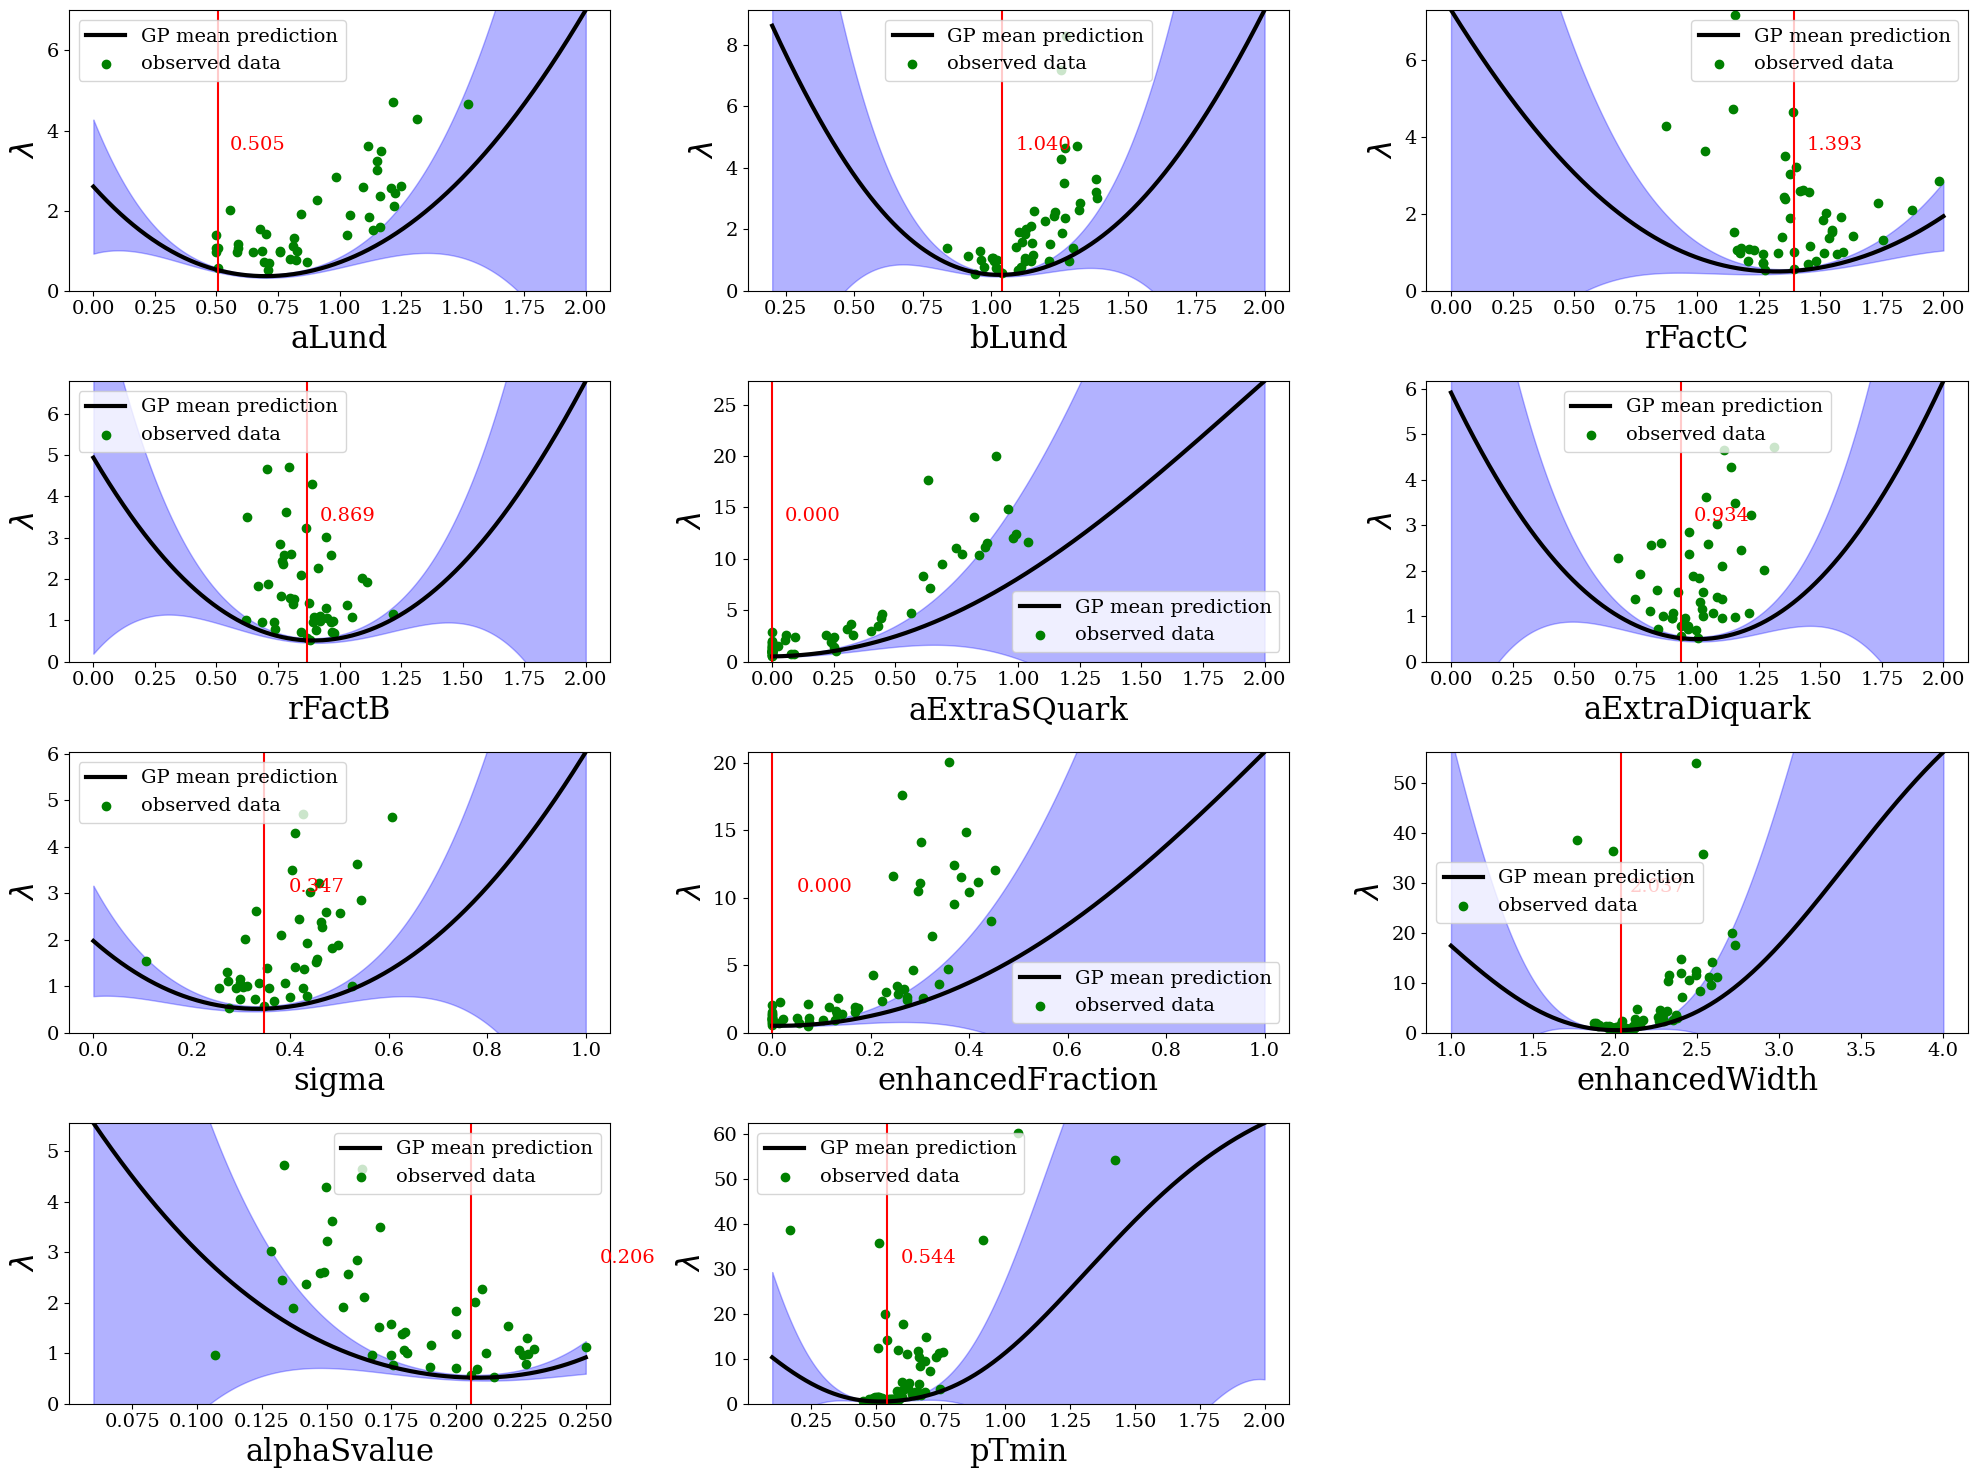

In [ ]:
fig, ax = plt.subplots(4, 3, figsize=(20,15))
ax = ax.ravel()
fig.delaxes(ax[-1])
for i, axi in enumerate(ax):
    params = list(MONASH_DICT.keys())
    plot_model_chi2_vs_param(param=params[i], reference_dict=best_parameters, ax=axi)

plt.tight_layout()
# plt.savefig(f'images/GP_lambda_vs_param_all_params.pdf')


In [ ]:
import torch
import numpy as np

def obj(z):
    y = ((z[0]-1.0)**2 + (z[1]-2.0)**2)
    y *=((z[0]-1.5)**2 + (z[1]-0.5)**2)
    y *=((z[0]-0.5)**2 + (z[1]-1.5)**2)
    return y

x0 = torch.tensor(np.random.uniform(0, 3, 2), requires_grad=True)
print(x0)
x  = x0

optimizer = torch.optim.Adam([x], lr=0.01)
n_iter = 1000
y_prev = torch.tensor([np.inf])
eps = 1.e-8

for i in range(n_iter):
    optimizer.zero_grad()
    y = obj(x)
    y.backward()
    optimizer.step()

    if torch.abs(y_prev-y) < eps:
        break
    y_prev = y

print(f'i: {i:5d}\ty: {float(y):10.3f}\tx: {str(x):s}')

tensor([0.1361, 2.3978], dtype=torch.float64, requires_grad=True)
i:   981	y:      0.000	x: tensor([0.9999, 1.9997], dtype=torch.float64, requires_grad=True)
